<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Introduction to Point Spread Function (PSF)</b> <br>
Contact author(s): Andrés A. Plazas Malagón<br>
Last verified to run:  08/17/2023 <br>
LSST Science Pipelines version: w_2023_21  <br>
Container Size: medium <br>
Targeted learning level: intermediate <br>

**Description:** This tutorial offers a comprehensive guide to Point Spread Function (PSF) properties, covering topics such as retrieval from catalogs and images, kernel generation, image display, size calculations, wavelength dependence, and diagnostic statistics like correlation functions.

**Skills:** Use of the catalog data products for PSF studies.

**LSST Data Products:**   DP0.2 collection: `2.2i/runs/DP0.2`. Dataset types: `calexp`, `deepCoadd`.  Catalogs: `dp02_dc2_catalogs.Object`, `dp02_dc2_catalogs.Source`.

**Packages:** lsst.afw.image, lsst.afw.detection, lsst.rsp, lsst.daf.butler, lsst.geom, lsst.afw.display, lsst.analysis.tools, lsst.pipe.base

**Credits:** Developed by Andrés A. Plazas Malagón in collaboration with Melissa Graham, Jeff Carlin, Douglas Tucker, and the Rubin Community Science Team for DP0.2. The `ImageExaminer` class, used for studying the PSF image profile and properties, is built upon the rapid-analysis code originally created by Merlin Fisher-Levine to characterize the Point Spread Function (PSF) of the Rubin Auxiliary Telescope LSST Atmospheric Transmission and Slitless Spectrograph (LATISS) images. The section on PSF size and its correlation function using the `treecorr` software is based on a Jupyter notebook authored by Claire-Alice Hebert. The section on PSF size histograms and their dependency on the central filter wavelength is derived from a Jupyter Notebook by Tianqing Zhang. The section on `rho` statistics using `lsst.analysis.tools` draws from a Jupyter Notebook by Arun Kannawadi.

This notebook incorporates suggestions from the [Accessible Authoring Checklist](https://iota-school.github.io/accessibility_hackathon/hack#checklist) and utilizes NASA's Astrophysics Data System Bibliographic Services.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

# The Point Spread Function (PSF)

## Table of contents
1.  Introduction.

    1.1. Package imports.
    
    1.2 Functions and Parameters Definitions.
    
2.  PSF image manipulation in `calexp` and `deepCoadd` images.

    2.1 PSF in `calexp` images.
    
    2.2 PSF in `deepCoadd` images.
    
    2.3 PSF properties for rapid analysis.
    
3. Size of the PSF and its correlation function using `treecorr`.

    3.1 Cone Search around the DC2 center using the `Object` catalog (`deepCoadd` images).
    
        3.1.1 Size calculation, visualization, and two-point correlation function calculation. 
    
    3.2 Cone Search around the DC2 center using the `Source` catalog (`calexp` images).
       
        3.2.1 Size calculation, visualization, and two-point correlation function calculation.
    
4. Wavelength dependence of seeing.

5. Rho statistics with `analysis_tools`.

## 1. Introduction

In the context of astronomical surveys, such as the Vera C. Rubin Legacy Survey of Space and Time (LSST), a significant objective is to extract cosmological information by scrutinizing subtle deviations in the shapes and orientations of galaxies. These deviations are caused by gravitational lensing from large-scale structures in the foreground. However, the observed shapes of galaxies are not solely influenced by the gravitational lensing effects of the universe's large-scale structure (referred to as "cosmic shear"), but also by a combined blurring effect known as the point spread function (PSF). The PSF arises from various factors such as atmospheric conditions (for ground-based instruments), telescope optics, and the image sensor.

The PSF can be understood as a function that describes how a bundle of rays, initially converging on a single point, spreads out spatially around that point. To accurately characterize the PSF, it is common to analyze the observed images of stars, which act as point sources before being distorted by the PSF. This analysis helps determine the convolution kernel, representing the size and shape of the blurring effect caused by the PSF. Accurate PSF modeling is crucial because any inaccuracies can lead to erroneous conclusions about fundamental aspects of the universe, such as the properties of dark matter and dark energy. Therefore, understanding and characterizing the PSF is essential to properly interpret and extract reliable cosmological information from astronomical observations.

This tutorial investigates the properties of the Point Spread Function using the DP0.2 dataset. It is composed of the following sections:

- Section 2 produces an image of the PSF model at a specific location in `calexp` and `deepCoadd` images. It then demonstrates how to calculate PSF profiles and contours, along with other properties such as size.

- Section 3 calculates and displays the size of the PSF in a particular photometric band (`i`) as a function of sky location. It also computes the size-size two-point correlation function (autocorrelation) using the `treecorr` software. This software is widely used in state-of-the-art weak lensing analyses to derive cosmological parameters. These calculations are performed using both `calexp` and `deepCoadd` images.

- Section 4 illustrates one chromatic dependence of the PSF: the wavelength dependence of the PSF size.

- Section 5 calculates the `rho` statistics, a series of two-point correlation functions used to diagnose the quality of a PSF model for weak lensing analyses. This calculation is done using the `lsst.afw.analysis.tools` framework.

#### Additional Resources

Review article: [Point Spread Function Modelling for Astronomical Telescopes: A Review Focused on Weak Gravitational Lensing Studies](https://ui.adsabs.harvard.edu/abs/2023arXiv230607996L/abstract)

[Treecorr Documentation](https://rmjarvis.github.io/TreeCorr/_build/html/index.html)

Chromatic effects of the PSF:

- Impact of Differential Chromatic Refraction (DCR) on weak lensing:  
 [Plazas and Bernstein 2012](https://ui.adsabs.harvard.edu/abs/2012PASP..124.1113P/abstract)
    
- Impact of DCR on Supernovae measurements: 
[Lee et al. 2023](https://ui.adsabs.harvard.edu/abs/2023AJ....165..222L/abstract)
    
- Impact of DCR, wavelength dependence of seeing, and other chromatic effects on weak lensing:
[Meyers and Burchat 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...807..182M/abstract)

PSF modeling and null tests for galaxy surveys, including `rho` statistics:

-  [Dark Energy Survey Y3 Results: Point Spread Function Modeling](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract)
-  [The Three-Year Shear Catalog of the Subaru Hyper Suprime-Cam SSP Survey](https://ui.adsabs.harvard.edu/abs/2022PASJ...74..421L/abstract)

PSF in coadded images: 

- [Mandelbaum et al. 2022](https://ui.adsabs.harvard.edu/abs/2023OJAp....6E...5M/abstract)

### 1.1. Package Imports

The [matplotlib](https://matplotlib.org/) (and especially sublibrary `matplotlib.pyplot`), [numpy](http://www.numpy.org/), [scipy](https://scipy.org/), and [astropy](http://www.astropy.org/) libraries are widely used Python libraries for plotting, scientific computing, scientific analysis, and astronomical data analysis.

The `lsst.rsp` package provides access to the Table Access Protocol (TAP) service for queries to the DP0 catalogs.

The `lsst.afw.image` provide visualization tools.

The `lsst.afw.display` library provides access to image visualization routines and the `lsst.daf.butler` library is used to access data products via the butler.

The `lsst.afw.analysis.tools` library provides acces to analysis tools.

The `lsst.geom` library provides the representation of a 2D coordinate `Point2D`.

The `lsst.pipe.base` library provides access to the `lsst.pipe.base.Struct` container.

[treecorr](https://rmjarvis.github.io/TreeCorr/_build/html/index.html) by [Jarvis et al. 2004](https://ui.adsabs.harvard.edu/abs/2004MNRAS.352..338J/abstract) is a widely used tool for fast correlations measurements based on a ball tree method (similar to a [k-d tree](https://en.wikipedia.org/wiki/K-d_tree)). In particular, it is widely used in state-of-the-art weak lensing cosmological analyses. 

In [1]:
%load_ext pycodestyle_magic
%flake8_on
import logging
logging.getLogger("flake8").setLevel(logging.FATAL)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import treecorr
from scipy.optimize import curve_fit
from matplotlib import cm
from numpy.linalg import norm
from matplotlib.ticker import LinearLocator
from matplotlib.offsetbox import AnchoredText

import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
import lsst.pipe.base as pipeBase
from lsst.rsp import get_tap_service
from lsst.geom import Point2D, radToDeg, SpherePoint, degrees
from lsst.analysis.tools.atools import RhoStatistics

### 1.2 Functions and Parameters Definitions

The following cell will set a standard figure size and `afwDisplay` backend to use throughout the notebook.

In [3]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)
afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')

The following hidden cell introduces the conversion factor between the standard deviation of a one-dimensional Gaussian profile and its full-width at half maximum (FWHM), a function characterized by a one-dimensional Gaussian profile, a power-law function, and the class `ImageExaminer`. The `ImageExaminer` class is utilized in section 2.3, "PSF Properties for Rapid Analysis," to scrutinize the image of the Point Spread Function at a specific location.

This class is constructed based on a [similar class](https://github.com/lsst-sitcom/summit_utils/blob/main/python/lsst/summit/utils/imageExaminer.py) developed by Merlin Fisher-Levine. The original class was designed for swift [analysis of images](https://roundtable.lsst.codes/rubintv/summit/auxtel/im_current) captured by the Rubin Auxiliary Telescope using the LATISS instrument, with the results typically displayed on [Rubin TV](https://roundtable.lsst.codes/rubintv). The `ImageExaminer` class includes various methods, such as producing contour, surface, and radial plots, along with calculating specific statistics of interest, including the PSF size (according to specific definitions of size).

Furthermore, the hidden cell incorporates auxiliary functions aimed at plotting instances of the `ImageExaminer` class and computing the properties of a given PSF model at a specific point.

To unveil the content of the hidden cell, opt for "View" from the menu bar, then select "Expand Selected Code." Alternatively, you can click on the vertical line adjacent to the cell or on the three dots that signify the cell's hidden status.

In [21]:
SIGMATOFWHM = 2.0*np.sqrt(2.0*np.log(2.0))


def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


def power(lam, a, b):
    return a*lam**(-b)


class ImageExaminer():
    """Class to examine PSF image properties.
    This is a simplified version---with minor modifications---of the
    code in
    https://github.com/lsst-sitcom/summit_utils/blob/main/python/lsst/summit/utils/imageExaminer.py
    """
    cutoutMappings = {"fitAmp": "Radial fitted amp",
                      "fitGausMean": "Radial fitted position",
                      "fitFwhm": "Radial fitted FWHM",
                      "eeRadius50": "50% flux radius",
                      "eeRadius80": "80% flux radius",
                      "eeRadius90": "90% flux radius"}

    def __init__(self, exp, *, centroid=None, boxHalfSize=None):
        self.exp = exp
        self.centroid = centroid
        self.data = exp.array
        xlen, ylen = self.data.shape
        if centroid is None:
            self.centroid = np.array([xlen/2, ylen/2])
        else:
            self.centroid = centroid
        if boxHalfSize is None:
            self.boxHalfSize = xlen // 2
        else:
            self.boxHalfSize = boxHalfSize
        self.xx, self.yy = self.getMeshGrid(self.data)
        self.imStats = pipeBase.Struct()
        self.radialAverageAndFit()

    def plotSurface(self, ax=None, useColor=True):
        """Make the surface plot.

        Parameters
        ----------
        ax : `maplotlib.axes`, optional.
            If ``None`` a new figure is created. Supply axes
            if including this as a subplot.
        useColor : `bool`, optional.
            Plot at as a surface if ``True``, else plot as a
            wireframe.
        """
        plotDirect = False
        if not ax:
            fig, ax = plt.subplots(subplot_kw={"projection": "3d"},
                                   figsize=(10, 10))
            plotDirect = True

        if useColor:
            _ = ax.plot_surface(self.xx, self.yy, self.data,
                                cmap=cm.plasma, linewidth=1,
                                antialiased=True, color='k', alpha=0.9)
        else:
            _ = ax.plot_wireframe(self.xx, self.yy,
                                  self.data, cmap=cm.gray,  # noqa F841
                                  linewidth=1, antialiased=True, color='k')

        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter('{x:,.0f}')
        ax.set_title("Surface plot")
        ax.set_xlabel('x (pix)')
        ax.set_ylabel('y (pix)')

        if plotDirect:
            plt.show()

    def plotContours(self, ax=None, nContours=10):
        """Make the contour plot.

        Parameters
        ----------
        ax : `maplotlib.axes`, optional
            If ``None`` a new figure is created. Supply axes
            if including this as a subplot.
        nContours : `int`, optional
            The number of contours to use.
        """
        plotDirect = False
        if not ax:
            fig = plt.figure(figsize=(8, 8))  # noqa F841
            ax = plt.subplot(111)
            plotDirect = True

        vmin = np.percentile(self.data, 0.1)
        vmax = np.percentile(self.data, 99.9)
        lvls = np.linspace(vmin, vmax, nContours)
        _ = ax.contour(self.xx, self.yy,
                       self.data, levels=lvls)

        ax.tick_params(which="both", direction="in",
                       top=True, right=True, labelsize=8)
        ax.set_aspect("equal")
        ax.set_title("Contour plot")
        ax.set_xlabel('x (pix)')
        ax.set_ylabel('y (pix)')

        if plotDirect:
            plt.show()

    def plotRowColSlices(self, ax=None):
        """Make the row and column slice plot.

        Parameters
        ----------
        ax : `maplotlib.axes`, optional
            If ``None`` a new figure is created. Supply axes
            if including this as a subplot.
        """
        rowSlice = self.data[self.boxHalfSize, :]
        colSlice = self.data[:, self.boxHalfSize]

        plotDirect = False
        if not ax:
            ax = plt.subplot(111)
            plotDirect = True

        xs = range(-1*self.boxHalfSize, self.boxHalfSize+1)
        ax.plot(xs, rowSlice, '--', label='Row plot')
        ax.plot(xs, colSlice, label='Column plot')
        ax.set_ylabel('Flux (ADU)')
        ax.set_xlabel('Radius (pix)')
        ax.set_aspect(1.0/ax.get_data_ratio(),
                      adjustable='box')
        ax.legend()
        ax.set_title("PSF slices")
        if plotDirect:
            plt.show()

    def plotRadialAverage(self, ax=None):
        """Make the radial average plot.

        Parameters
        ----------
        ax : `maplotlib.axes`, optional
            If ``None`` a new figure is created. Supply axes
            if including this as a subplot.
        """
        plotDirect = False
        if not ax:
            ax = plt.subplot(111)
            plotDirect = True

        distances = self.radialDistances
        values = self.radialValues
        pars = (self.imStats.fitAmp,
                self.imStats.fitGausMean,
                self.imStats.fitFwhm / SIGMATOFWHM)

        fitFailed = np.isnan(pars).any()

        ax.plot(distances, values, 'x', label='Radial average')
        if not fitFailed:
            fitline = gauss(distances, *pars)
            ax.plot(distances, fitline, label="Gaussian fit")

        ax.set_ylabel('Flux (ADU)')
        ax.set_xlabel('Radius (pix)')
        ax.set_aspect(1.0/ax.get_data_ratio(),
                      adjustable='box')
        ax.legend()
        ax.set_title("Azimuthally-averaged radial profile.")

        if plotDirect:
            plt.show()

    def radialAverageAndFit(self):
        """Calculate flux vs radius from the star's centroid and fit the width.

        Calculate the flux vs distance from the star's
        centroid and fit a Gaussian to get a measurement of the width.

        Also calculates the various encircled energy metrics.

        Notes
        -----
        Nothing is returned, but sets many value in the class.
        """
        xlen, ylen = self.data.shape
        center = np.array([xlen/2, ylen/2])
        distances = []
        values = []

        for i in range(xlen):
            for j in range(ylen):
                value = self.data[i, j]
                dist = norm((i, j) - center)
                if dist > xlen//2:
                    # clip to box size, we don't need a factor
                    # of sqrt(2) extra
                    continue
                values.append(value)
                distances.append(dist)

        peakPos = 0
        amplitude = np.max(values)
        width = 10

        bounds = ((0, 0, 0), (np.inf, np.inf, np.inf))

        try:
            pars, pCov = curve_fit(gauss, distances, values,
                                   [amplitude, peakPos, width],
                                   bounds=bounds)
            pars[0] = np.abs(pars[0])
            pars[2] = np.abs(pars[2])
        except RuntimeError:
            pars = None
            self.imStats.fitAmp = np.nan
            self.imStats.fitGausMean = np.nan
            self.imStats.fitFwhm = np.nan

        if pars is not None:
            self.imStats.fitAmp = pars[0]
            self.imStats.fitGausMean = pars[1]
            self.imStats.fitFwhm = pars[2] * SIGMATOFWHM

        self.radialDistances = distances
        self.radialValues = values

        # calculate encircled energy metric too
        # sort distances and values in step by distance
        d = np.array([(r, v) for (r, v) in sorted(zip(self.radialDistances,
                                                      self.radialValues))])
        self.radii = d[:, 0]
        values = d[:, 1]
        self.cumFluxes = np.cumsum(values)
        self.cumFluxesNorm = self.cumFluxes/np.max(self.cumFluxes)
        self.imStats.eeRadius50 = self.getEncircledEnergyRadius(50)
        self.imStats.eeRadius80 = self.getEncircledEnergyRadius(80)
        self.imStats.eeRadius90 = self.getEncircledEnergyRadius(90)

        return

    def plotCurveOfGrowth(self, ax=None):
        """Make the encircled energy plot.

        Parameters
        ----------
        ax : `maplotlib.axes`, optional
            If ``None`` a new figure is created. Supply axes
            if including this as a subplot.
        """
        plotDirect = False
        if not ax:
            ax = plt.subplot(111)
            plotDirect = True

        ax.plot(self.radii, self.cumFluxesNorm, markersize=10)
        ax.set_ylabel('Encircled flux (%)')
        ax.set_xlabel('Radius (pix)')

        ax.set_aspect(1.0/ax.get_data_ratio(),
                      adjustable='box')
        ax.set_title("Encircled flux")

        if plotDirect:
            plt.show()

    def plotStats(self, ax, lines):
        """Make the stats box 'plot'.

        Parameters
        ----------
        ax : `maplotlib.axes`
            Axes to use.
        lines : `list` of `str`
            The data to include in the text box
        """
        text = "\n".join([line for line in lines])

        stats_text = AnchoredText(text, loc="center", pad=0.5,
                                  prop=dict(size=14, ma="left",
                                            backgroundcolor="white",
                                            color="black", family='monospace'))
        ax.add_artist(stats_text)
        ax.axis('off')

    def getStarBoxData(self):
        """Get the image data for the star.

        Calculates the maximum valid box, and uses that
        to return the image data, setting self.starBbox
        as this method changes the bbox.

        Returns
        -------
        data : `np.array`
            The image data
        """
        bbox = self._calcBbox(self.centroid)
        self.starBbox = bbox

        return self.exp.image[bbox].array

    def getMeshGrid(self, data):
        """Get the meshgrid for a data array.

        Parameters
        ----------
        data : `np.array`
            The image data array.

        Returns
        -------
        xxyy : `tuple` of `np.array`
            The xx, yy as calculated by np.meshgrid
        """
        xlen, ylen = data.shape
        xx = np.arange(-1*xlen/2, xlen/2, 1)
        yy = np.arange(-1*ylen/2, ylen/2, 1)
        xx, yy = np.meshgrid(xx, yy)
        return xx, yy

    def getEncircledEnergyRadius(self, percentage):
        """Radius in pixels with the given percentage of
            encircled energy.

        100% is at the boxHalfWidth dy definition.

        Parameters
        ----------
        percentage : `float` or `int`
            The percentage threshold to return.

        Returns
        -------
        radius : `float`
            The radius at which the ``percentage`` threshold
            is crossed.
        """
        return self.radii[np.argmin(
            np.abs((percentage/100)-self.cumFluxesNorm))]

    @staticmethod
    def translateStats(imStats, mappingDict):
        """Create the text for the stats box from the stats
            themselves.

        Parameters
        ----------
        imStats : `lsst.pipe.base.Struct`
            A container with attributes containing measurements
            and statistics for the image.
        mappingDict : `dict` of `str`
            A mapping from attribute name to name for rendereding
            as text.

        Returns
        -------
        lines : `list` of `str`
            The translated lines of text.
        """
        lines = []
        for k, v in mappingDict.items():
            try:
                value = getattr(imStats, k)
            except Exception:
                lines.append("")
                continue

            if type(value) == float or isinstance(value, np.floating):
                value = f"{value:,.3f}"
            if k == 'centroid':
                value = f"{value[0]:.1f}, {value[1]:.1f}"
            lines.append(f"{v} = {value}")
        return lines


def get_psf_properties(psf, point):
    """Function to obtain PSF properties.

    Parameters
    ----------
    psf : `lsst.meas.extensions.psfex.PsfexPsf`
        PSF object.
    point : `lsst.geom.Point2D`
        Coordinate where the PSF is being evaluated.

    Returns
    -------
        sigma : `float`
            PSF determinat radius from SDDS adaptive
            moments matrix.
        ap_flux : `float`
            PSF flux from aperture photometry weighted
            by a sinc function.
        peak : `float`
            Peak PSF value.
        av_pos : `lsst.geom.Point2D'
            Average PSF position.
        dims : `lsst.geom.ExtendI`
            PSF postage stamp dimensions.
    """
    sigma = psf.computeShape(point).getDeterminantRadius()
    ap_flux = psf.computeApertureFlux(radius=sigma, position=point)
    peak = psf.computePeak(position=point)
    av_pos = psf.getAveragePosition()
    dims = psf.computeImage(point).getDimensions()

    print(f"PSF size: {sigma:.4} pix \n"
          f"PSF flux from aperture photometry: {ap_flux:.4} \n"
          f"Peak PSF value: {peak:.4} \n"
          f"Average PSF position: {av_pos} \n"
          f"PSF dimensions: {dims} \n")

    return (sigma, ap_flux, peak, av_pos, dims)


def plotPsfImageExaminer(psfImageExaminer):
    """Function to plot `ImageExaminer` instances.

    Parameters
    ----------
    psfImageExaminer: `ImageExaminer`
        `ImageExaminer` object.
    """
    figsize = 6
    fig = plt.figure(figsize=(figsize*2, 3*figsize))

    axSurface = fig.add_subplot(321, projection='3d')
    axContour = fig.add_subplot(322)
    axStats = fig.add_subplot(323)
    axSlices = fig.add_subplot(324)
    axRadial = fig.add_subplot(325)
    axEncircled = fig.add_subplot(326)

    psfImageExaminer.plotSurface(axSurface)
    psfImageExaminer.plotContours(axContour)
    psfImageExaminer.plotRowColSlices(axSlices)
    psfImageExaminer.plotRadialAverage(axRadial)

    lines = []
    lines.append("\n     ---- Cutout ----")
    lines.extend(psfImageExaminer.translateStats(
        psfImageExaminer.imStats,
        psfImageExaminer.cutoutMappings))

    psfImageExaminer.plotStats(axStats, lines)
    psfImageExaminer.plotCurveOfGrowth(axEncircled)

    return

### 2. PSF image manipulation in `calexp` and `deepCoadd` images.

The initial stage in processing LSST science observations involves Instrument Signature Removal (ISR). This encompasses fundamental detrending operations like flat-fielding, bias subtraction, fringe correction, and rectification of flawed and oversaturated pixels. Subsequently, the focus shifts to characterizing single-epoch direct images, constructing models that depict the observational system and its conversion of the true celestial scene into the observed image. This process encompasses background subtraction, PSF modeling, addressing cosmic ray effects, applying aperture corrections, and source measurement. After segregating stars and galaxies, the PSF model in single-epoch images is assembled using data from a star catalog. The LSST Science Pipelines have transitioned to using the PIFF (PSF in the Full-Field of View) code for PSF modeling in the full field of view, replacing the Point Spread Function Extractor, [PSFEx](https://ui.adsabs.harvard.edu/abs/2013ascl.soft01001B/abstract), software. However, the current approach to PSF coaddition is somewhat simplified and not optimally suited for weak lensing research. When the PSF model is requested at a specific point in a coadded image, all the PSF models from the single-epoch images that constitute that coadd are aggregated with the same weighting scheme used for creating the coadded image. The LSST Science Pipelines are in the process of implementing a more robust and clearly defined PSF coaddition procedure (as discussed in [Mandelbaum et al. 2022](https://ui.adsabs.harvard.edu/abs/2023OJAp....6E...5M/abstract)), based on measurements from coadded regions known as "cell-based coadds" (detailed in [Sheldon et al. 2023](https://ui.adsabs.harvard.edu/abs/2023OJAp....6E..17S/abstract)).

In the forthcoming sections, we will generate an image of the PSF model at a specific location within both a `calexp` and a `deepCoadd` image.

#### 2.1 PSF in `calexp` images.

Define the Butler instance for DP0.2 and select a particular `calexp` image. We will pass the `visit` and `detector` numbers in order to uniquely constrain the image, and will visualize the imaga afterwards.

In [4]:
config = 'dp02'
collections = '2.2i/runs/DP0.2'
butler = dafButler.Butler(config, collections=collections)

In [5]:
datasetType = 'calexp'
dataId = {'visit': 192350, 'detector': 175}
calexp = butler.get(datasetType, dataId=dataId)

The following plot is a 2D image of the `calexp` from the previous butler query, in pixel coordinates ranging from 0 to 4000 pixels in both axes, and with a contrast bar ranging from -300 to 400 digital units. Point and extended sources are scattered around the image. We will retrieve PSF models at particular points in this image.

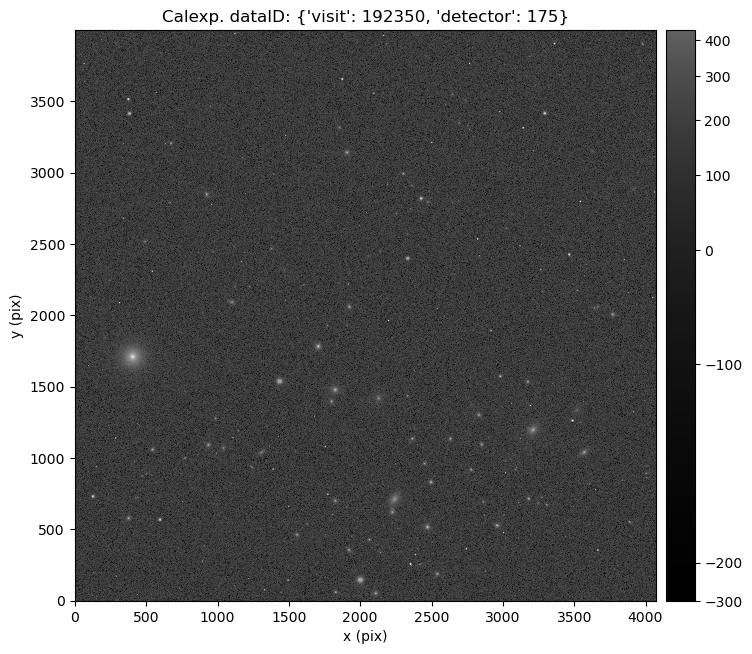

In [6]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(calexp.image)
plt.title(f'Calexp. dataID: {dataId}')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.show()

We will use `computeKernelImage` to display the pixel-based model of the PSF at a particular point with coordinates `(x, y) = (2000, 3500)` (denoted by the `point_tuple` variable).

In [7]:
point_tuple = (2000, 3500)
point_image = Point2D(point_tuple)

In the following cell, we extract the PSF model from the exposure information, obtained from the calexp object itself.

In [11]:
info_calexp = calexp.getInfo()
psf_calexp = info_calexp.getPsf()

We are now prepared to employ computeKernelImage to evaluate the PSF model at the location defined in the point_tuple variable.

In [12]:
psf_calexp_kernel = psf_calexp.computeKernelImage(point_image)
first_psf_image_calexp = psf_calexp_kernel.convertF()

The subsequent plot depicts a postage stamp or cut-out of a PSF model extracted from a `calexp` image using the `computeKernelImage` function. The PSF is centered at the origin, and the stamp is rectangular, encompassing 40 pixels and spanning from negative 20 to positive 20 pixels on each side. The color contrast bar spans a range from approximately negative 0.0002 to about 0.0003.

(-20.5, 20.5, -20.5, 20.5)

<Figure size 1000x800 with 0 Axes>

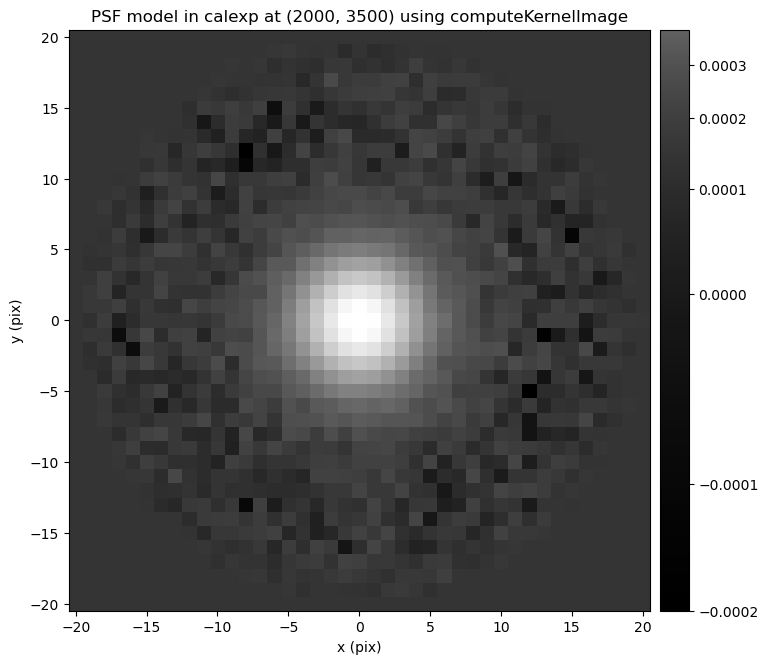

In [13]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(first_psf_image_calexp)
plt.title(f'PSF model in calexp at {point_image} using computeKernelImage')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.gca().axis('on')

Note that the image coordinates are centered at the origin of the image. The coordinates of this origin point are (0,0), resulting in negative coordinates for the lower left point:

In [14]:
print(first_psf_image_calexp.getXY0())

(-20, -20)


Now, instead of using `computeKernelImage`, we will utilize `computeImage`. The former positions the PSF center at the center of the central pixel within the stamp or cutout (`computeKernelImage`). On the other hand, the latter (`computeImage`) allows the PSF center to be placed at any arbitrary location. To achieve this, we require the astrometric solution, often referred to as the "World Coordinate System" (WCS) in the code, which maps pixel coordinates to sky coordinates and can also be obtained form the exposure information, as the PSF model. The "WCS" nomenclature is used for historical reasons. Note also that we need to convert the `point_tuple` variable into an `lsst.geom.Point2D` object first. 

In [18]:
wcs_calexp = info_calexp.getWcs()
point_object = Point2D(point_tuple)
second_psf_image_calexp = psf_calexp.computeImage(point_object).convertF()

The following plot shows a postage stamp or cut-out of a PSF model from a `calexp`, obtained using `computeKernelImage`. The PSF is centered around zero, and the stamp is rectangular, with a size of 40 pixels, ranging from 1980 to 2020 pixels on the `x` axis and from about 3480 to 3520 on the `y` axis. The contrast bar ranges from negative 0.0002 to about 0.0003. 

(1979.5, 2020.5, 3479.5, 3520.5)

<Figure size 1000x800 with 0 Axes>

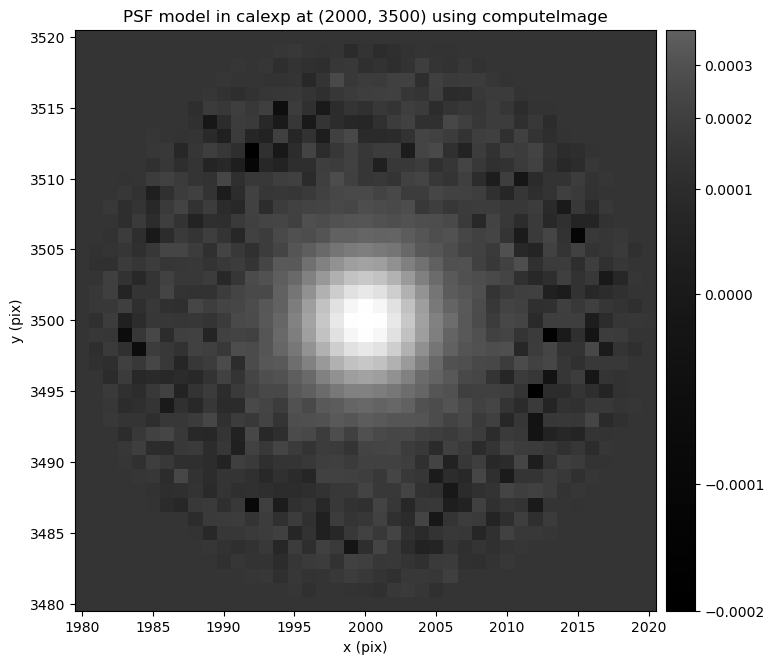

In [17]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(second_psf_image_calexp)
plt.title(f'PSF model in calexp at {point_image} using computeImage')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.gca().axis('on')

In [19]:
print(second_psf_image_calexp.getXY0())

(1980, 3480)


Now let’s use one of the helper functions we defined earlier — `get_psf_properties` — to calculate some PSF properties at a particular point:

In [22]:
props = get_psf_properties(psf_calexp, point_image)

PSF size: 1.612 pix 
PSF flux from aperture photometry: 0.3659 
Peak PSF value: 0.05834 
Average PSF position: (2020.2, 1772.1) 
PSF dimensions: (41, 41) 



#### 2.2 PSF in `deepCoadd` images.

When conducting multi-epoch surveys for static-sky science, the traditional method involves creating coadds. This process entails resampling images from different observations onto a common grid and averaging them to generate a single, deeper image known as a `deepCoadd`. Additionally, a coadded point spread function (PSF) model is established. Handling PSF coadding with care is crucial to ensure a well-defined PSF.

One of the challenges in coadding PSFs arises from slight variations observed between PSFs in different visits. Even minor differences make it practically impossible to accurately model the effective PSF of the coadd using coadded star images. Even small positional shifts, known as dithers, used to fill the gaps between charge-coupled devices introduce disruptions in the effective PSF of the coadd. As the number of dithers increases, the areas within the coadd with a continuous effective PSF become smaller, making it increasingly unlikely to find stars suitable for PSF modeling in each region. For the Hyper-Suprime Camera survey, [Bosch et al 2018](https://ui.adsabs.harvard.edu/abs/2018PASJ...70S...5B/abstract) use an approach that involves resampling and combining existing PSF models from the input images using the same coordinate transformations and weights applied to the image data. The Hyper-Suprime Camera survey analysis pipeline is based on the LSST Science Pipelines code.

[Mandelbaum et al. 2022](https://ui.adsabs.harvard.edu/abs/2023OJAp....6E...5M/abstract) provide a mathematical framework that aids in producing well-defined coadded PSFs. It's important to note that the results obtained using this approach are specifically applicable to static sources. As indicated in footnote 2 on page 4 of [Mandelbaum et al. 2022](https://ui.adsabs.harvard.edu/abs/2023OJAp....6E...5M/abstract), the coadd PSF for time-varying sources will vary depending on their light curves. For instance, if a variable or transient source appears very bright in just one exposure and faint in all others, its coadd PSF will essentially match that of the exposure where it is bright. This effect may introduce additional challenges for the LSST. The initial survey plan proposed using two 15-second "snaps" combined into a single 30-second exposure for each visit. Whether this approach will be implemented is still under consideration, but if adopted, the issue of PSF for time-varying objects in a coadd becomes relevant even in the process of combining the two snaps.

We will visualize the PSF model in a `deepCoadd` image similar to section 2.1, but this time using a `deepCoadd` image. We will select the same point in the sky that we used to represent the PSF in the `calexp` of the previous section. This will allow us to better appreciate the differences between the `deepCoadd` and an individual `calexp` PSF model.

First, we will retrieve the right ascension and declination coordinates of the point we used in the previous section (stored in the variable `point_tuple`), as well as the band of that exposure. Then, we will follow the steps outlined in section 3.2 of the Notebook tutorial `DP02_01` to determine the `tract` and `patch` of the `deepCoadd`. This information, along with the `band`, will uniquely define a data ID that we can provide to the butler to access the corresponding `deepCoadd`.

This time, we will pass both the `tract` and `patch` numbers, along with the desired band (`i`), to uniquely specify the image we're interested in.

In [23]:
x, y = point_tuple
ra, dec = wcs_calexp.pixelToSky(x, y)
my_ra_deg = radToDeg(ra)
my_dec_deg = radToDeg(dec)
print(my_ra_deg, my_dec_deg)

53.01240743567535 -34.1195835309739


In [24]:
my_band = info_calexp.getFilter().bandLabel
print(my_band)

i


In [25]:
my_spherePoint = SpherePoint(my_ra_deg*degrees,
                             my_dec_deg*degrees)
print(my_spherePoint)

skymap = butler.get('skyMap')

tract = skymap.findTract(my_spherePoint)
patch = tract.findPatch(my_spherePoint)

my_tract = tract.tract_id
my_patch = patch.getSequentialIndex()

print('my_tract: ', my_tract)
print('my_patch: ', my_patch)

(53.0124074357, -34.1195835310)
my_tract:  4225
my_patch:  3


In [26]:
datasetType = 'deepCoadd'
dataId = {'tract': my_tract, 'patch': my_patch, 'band': my_band}
coadd = butler.get(datasetType, dataId=dataId)

The following plot is a 2D image of the `deepCoadd` from the previous butler query, in pixel coordinates ranging from 12000 to 16000 pixels in the horizontal axis and 0 to 4000 pixels in the vertical axis. The contrast bar ranges from negative 0.2 to 0.3 digital units. Point and extended sources are scattered around the image, however, a galaxy cluster is particularly prominent inthe lower left part of the image.

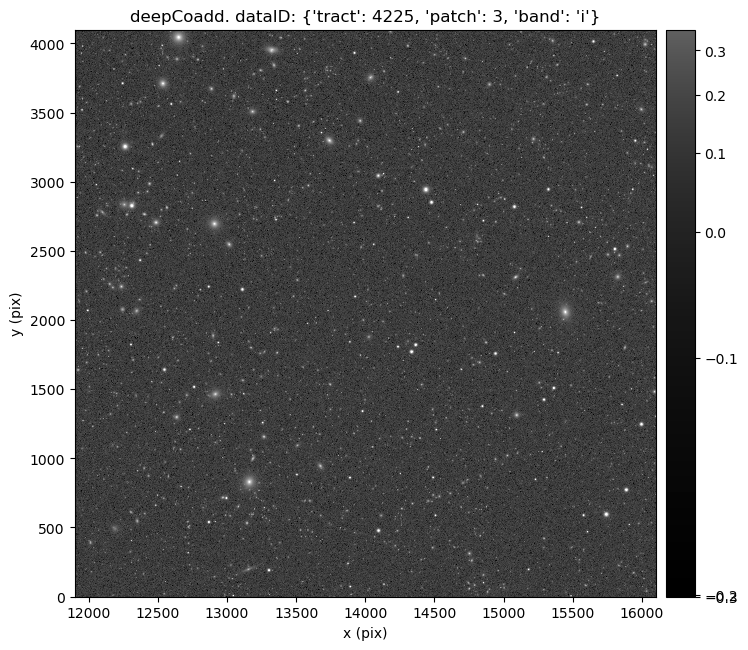

In [27]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(coadd.image)
plt.title(f'deepCoadd. dataID: {dataId}')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.show()

In order to use the same point as in the example above with the `calexp`, we will retrieve first the WCS for the coadd information, and convert the sky point to local pixel coordinates in the `deepCoadd` image displayed in the previous cell.   

In [36]:
info_coadd = coadd.getInfo()
wcs_coadd = info_coadd.getWcs()
point_image = wcs_coadd.skyToPixel(my_spherePoint)
point_image

Point2D(12937.473803968331, 2324.9666227765465)

We will use `computeKernelImage` to display the pixel-based model of the PSF at a particular point. Note the higher signal-to-noise ratio in this image, compared to the single `calexp` PSF image in Section 2.1

In [37]:
psf_coadd = info_coadd.getPsf()
psf_kernel_coadd = psf_coadd.computeKernelImage(point_image)
first_psf_image_coadd = psf_kernel_coadd.convertF()

The following plot shows a postage stamp or cut-out of a PSF model from a `deepCoadd` image, obtained using `computeKernelImage`. The PSF is centered around zero, and the stamp is rectangular, with a size of about 50 pixels, ranging from -25 to 25 pixels on each size. The contrast bar ranges from -1e-5 to 7e-5 . 

(-28.5, 28.5, -28.5, 28.5)

<Figure size 1000x800 with 0 Axes>

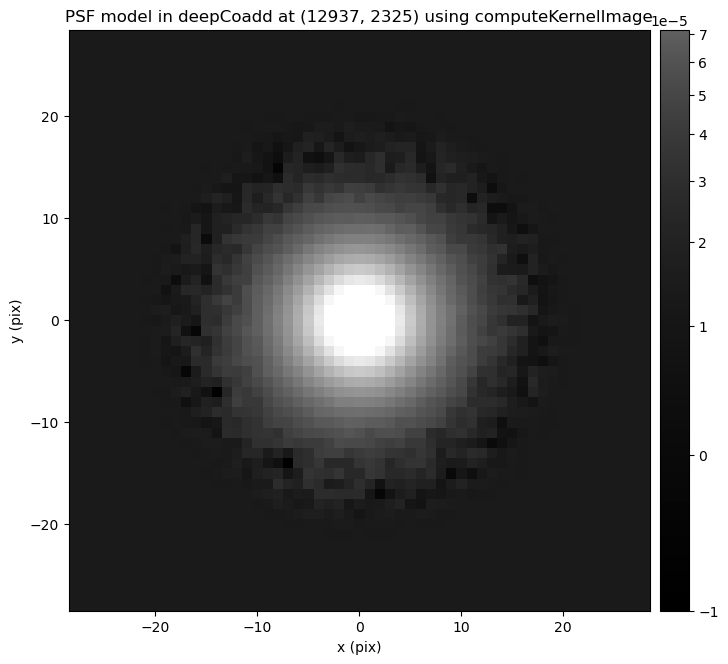

In [38]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(first_psf_image_coadd)
plt.title(f'PSF model in deepCoadd at {point_image} using computeKernelImage')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.gca().axis('on')

Print the coordinates of the origin:

In [39]:
print(first_psf_image_coadd.getXY0())

(-28, -28)


Now, instead of `computeKernelImage`, we'll use
`computeImage`. 
One have the PSF center at the center of the 
central pixel in the stamp or cutout (computeKernelImage), and 
the other one (computeImage) can make it at any arbitrary location.

In [40]:
second_psf_image_coadd = psf_coadd.computeImage(point_image).convertF()

The following plot shows a postage stamp or cut-out of a PSF model from a `deepCoadd` image, obtained using `computeImage`. The PSF is no longer centered around zero as when we used `computKernelImage`, but centered at about 13000 and 8500 pixels. The stamp is still rectangular, with a size of about 50 pixels, ranging from 12970 to 13030 pixels on the horizantal axis and 8470 to 8530 on the vertical axis. The contrast bar ranges from negative 1e-5 to 7e-5 .

(12908.5, 12965.5, 2296.5, 2353.5)

<Figure size 1000x800 with 0 Axes>

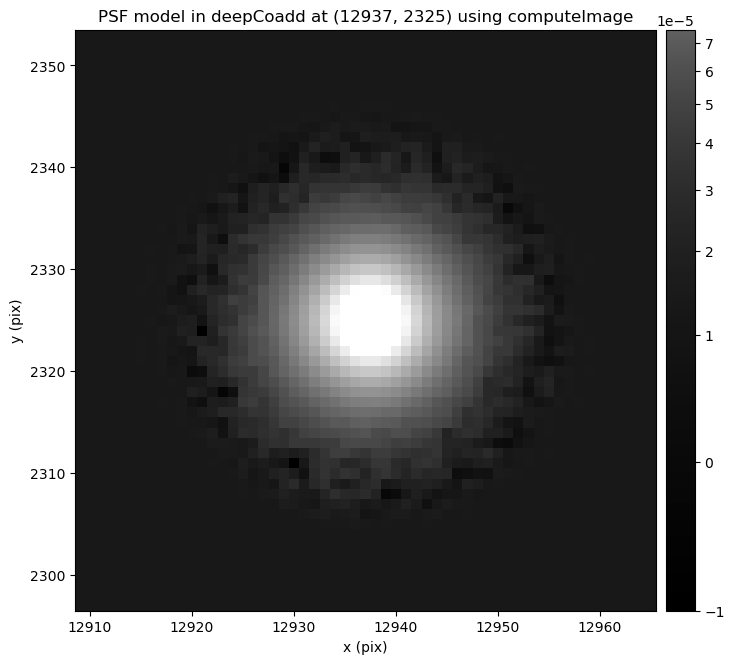

In [41]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(second_psf_image_coadd)
plt.title(f'PSF model in deepCoadd at {point_image} using computeImage')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.gca().axis('on')

Look at the coordinates of the origin:

In [42]:
second_psf_image_coadd.getXY0()

Point2I(12909, 2297)

Calculate the PSF properties, as in Section 2.1 for the `calexp` PSF:

In [43]:
props_psf_coadd = get_psf_properties(psf_coadd, point_image)

PSF size: 1.75 pix 
PSF flux from aperture photometry: 0.3591 
Peak PSF value: 0.0492 
Average PSF position: (14016, 2010.4) 
PSF dimensions: (57, 57) 



#### 2.3.  PSF properties for rapid analysis.

In this section, we will utilize the `ImageExaminer` class that was introduced in section 1.2 of this tutorial. Our aim is to visualize the PSFs from both `calexp` and `deepCoadd` images discussed in sections 2.1 and 2.2. We will achieve this by employing surface and contour plots. Additionally, we will generate one-dimensional profiles of the central PSF along both the horizontal and vertical axes, along with creating an azimuthally-averaged radial profile of the PSF. We intend to fit a Gaussian function to this radial profile. Lastly, we will present a plot depicting the encircled flux as a function of radius. We will also showcase the results of fitting a Gaussian function to the radial profile, including parameters such as amplitude, size (Full-Width at Half-Maximum), and centroid, along with the radii corresponding to 50%, 80%, and 90% encircled fluxes.

The code for this section is grounded in the [imageExaminer.py](https://github.com/lsst-sitcom/summit_utils/blob/main/python/lsst/summit/utils/imageExaminer.py) class. This class is currently employed for the [swift PSF analysis of the LATISS images](https://roundtable.lsst.codes/rubintv/summit/auxtel/im_current) obtained by Rubin's AuxTel at Cerro Pachón, Chile.

Let's now produce the plots for the`calexp` PSF of section 2.1. We'll start by making an instance of the `ImageExaminer` class.

In [45]:
psfImageExaminerCalexp = ImageExaminer(first_psf_image_calexp)

The following cell will generate a plot comprising 6 panels, organized into 3 rows and 2 columns. In the upper left plot, a three-dimensional surface representation of the `calexp` PSF within the specified postage stamp range will be displayed. The upper right plot will present a two-dimensional contour plot showcasing the PSF centered at its core.

Moving to the middle row, the left panel will provide a condensed overview of key statistics. These statistics will report the amplitude, width, and centroid derived from a one-dimensional Gaussian fit applied to the azimuthally averaged radial profile of the PSF. Furthermore, the panel will detail three encircled flux radii, corresponding to 50%, 80%, and 90% of the encircled flux, respectively. The right panel of this middle row will display the one-dimensional radial profiles. These profiles are formed by slicing the 2D PSF image along the central axes in both the horizontal and vertical directions.

The left panel of the final row will depict the azimuthally averaged PSF radial profile, accompanied by a curve representing the Gaussian fit to the data. The right panel of this row will showcase a cumulative plot with a monotonically increasing curve, illustrating the percentage of encircled flux emanating from the PSF profile's center as a function of the radius in pixels.

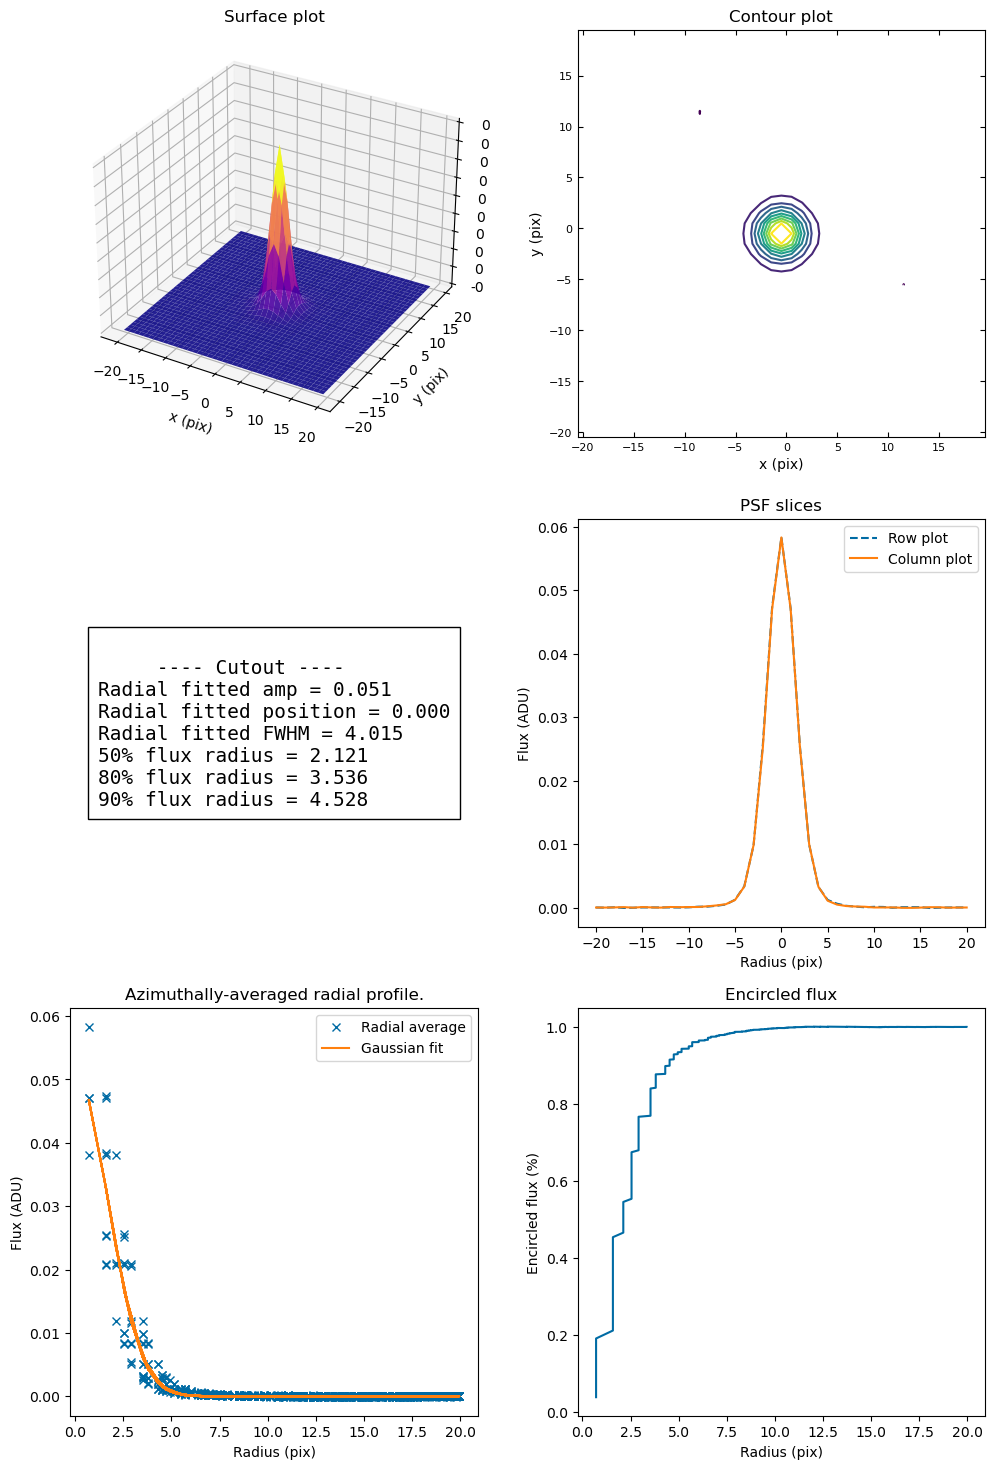

In [46]:
plotPsfImageExaminer(psfImageExaminerCalexp)

And now let's do the plotting for the PSF from the `deppCoadd` of section 2.2.

In [48]:
psfImageExaminerCoadd = ImageExaminer(first_psf_image_coadd)

The upcoming cell will generate a plot featuring 6 panels, arranged in a grid with 3 rows and 2 columns. In the upper left plot, a three-dimensional surface representation of the `deepCoadd` PSF within the specified postage stamp range will be depicted. The upper right plot will display a two-dimensional contour representation of the PSF, centered at its core.

Moving to the middle row, the left panel will encapsulate a summary of crucial statistics. These statistics encompass the amplitude, width, and centroid derived from a one-dimensional Gaussian fit applied to the azimuthally averaged radial profile of the PSF. Additionally, this panel will provide details about three encircled flux radii, corresponding to 50%, 80%, and 90% of the encircled flux, respectively. The right panel of this middle row will exhibit the one-dimensional radial profiles, constructed by slicing the 2D PSF image along the central axes in both horizontal and vertical directions.

The left panel of the final row will visualize the azimuthally averaged PSF radial profile, alongside a curve resulting from the Gaussian fit to the data. The right panel of this row will showcase a cumulative plot with a monotonically increasing curve, illustrating the percentage of encircled flux originating from the center of the PSF profile as a function of radius in pixels. It's noteworthy that since the displayed PSF is a model built from coadded images, the plots and profiles exhibit a higher signal-to-noise ratio in comparison to the analogous plots from a previous cell, created for a `calexp` PSF.

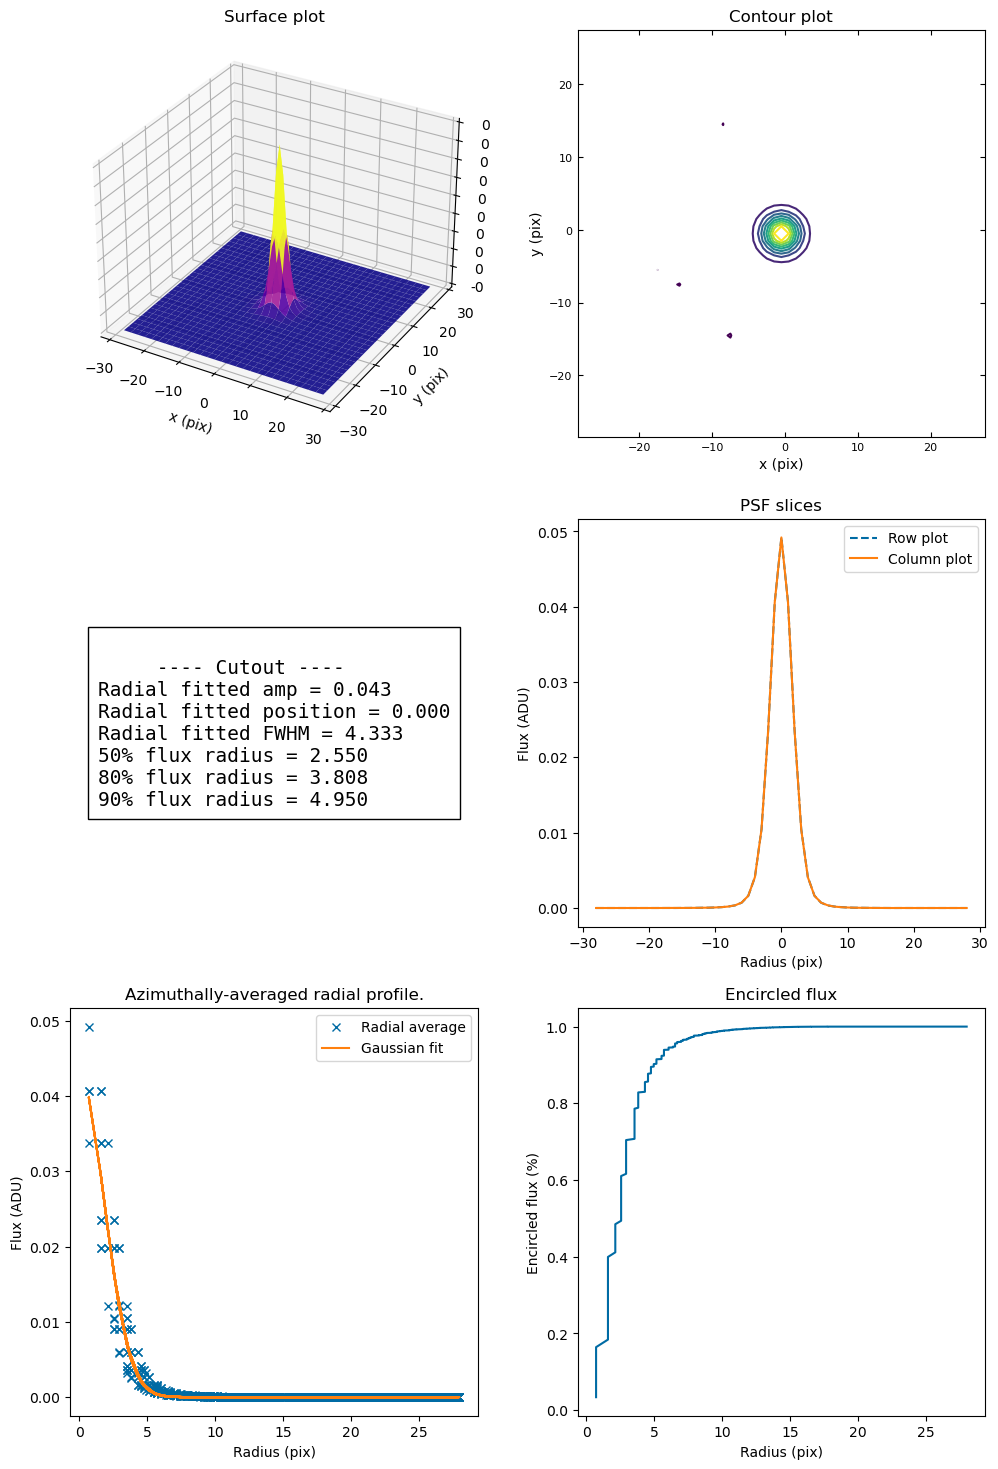

In [49]:
plotPsfImageExaminer(psfImageExaminerCoadd)

#### 3. Size of the PSF and its correlation function using `treecorr`.

In this section, our focus will be on plotting the size of the `deepCoadd` PSF in the `i` band as a function of celestial coordinates. To achieve this, we will utilize the TAP service to retrieve point sources from the `deepCoadd` catalog, along with the necessary parameters. Once we've calculated the PSF size based on the modeled PSF second moments, we will visualize it with respect to sky coordinates. 

Moreover, we will harness the capabilities of the `treecorr` software to compute the two-point correlation function of the size, considering angular separation as the variable of interest. Two-point correlation functions hold significant importance in weak lensing cosmological analysis, as they allow us to infer crucial cosmological parameters. Notably, `treecorr` serves as the standard tool employed by various collaborations, including the Dark Energy Survey and the Hyper-Suprime Camera Survey. It's also a prominent choice utilized by the LSST Science Pipelines code.

#### 3.1 Cone Search around the DC2 center using the `Object` catalog (`deepCoadd` images).  
Let's conduct a cone search (similar to DP0.2 NB2) centered around the DC2 central point, with a search radius of 2 degrees. The query below utilizes the `Object` catalog, which houses the `deepCoadd` objects (refer to the [DP0.2 schema browser](https://dm.lsst.org/sdm_schemas/browser/dp02.html#Object)). Our query seeks PSF fluxes in various bands, derived from fitting a PSF model to a specific set of stars. We'll utilize the second moments of the PSF, denoted as `{band}_ixxPSF`, `{band}_ixyPSF`, and `{band}_iyyPSF`, to calculate the PSF size for each band.

In this section, our focus is on plotting the PSF size exclusively in one band (`i`). However, in the subsequent section (section 4), we'll illustrate the relationship between PSF size and seeing by employing different bands. To identify point sources, we've set the flags `detect_isPrimary` and `i_extendedness` to 1 and 0.0, respectively. The presence of the `i_calib_psf_used` flag ensures our selection of stars that were utilized (rather than reserved) for establishing the PSF model (refer, for instance, to [Jarvis et al. 2020](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract)).

To ensure that the chosen objects aren't near edges, the `i_pixelFlags_inexact_psfCenter = 0` flag is employed. This choice is influenced by the fact that the `EDGE` flag in a `calexp` corresponds to the `SENSOR_EDGE` flag in the `coadd`. Objects near these edges have a discontinuous PSF. Additionally, the `inexact_psfCenter` results from an `OR` operation that includes `SENSOR_EDGE`. The other properties retrieved through the query will play a role in calculating the `rho` statistics, which will be the subject of section 5 in this notebook.

In [50]:
service = get_tap_service("tap")

In [51]:
use_center_coords = "62, -37"
band = 'i'

The following query could take more than a minute.

In [52]:
results = service.search("SELECT TOP 1000000"
                         "coord_ra, coord_dec, "
                         "scisql_nanojanskyToAbMag(u_psfFlux) as u_psfMag, "
                         "scisql_nanojanskyToAbMag(g_psfFlux) as g_psfMag, "
                         "scisql_nanojanskyToAbMag(r_psfFlux) as r_psfMag, "
                         "scisql_nanojanskyToAbMag(i_psfFlux) as i_psfMag, "
                         f"scisql_nanojanskyToAbMagSigma({band}_psfFlux, "
                         f"{band}_psfFluxErr) "
                         f"as {band}_psfMagErr, "
                         f"{band}_psfFlux, "
                         f"{band}_psfFlux_flag, "
                         f"{band}_pixelFlags_saturatedCenter, "
                         f"{band}_extendedness_flag, "
                         "xy_flag, detect_isPatchInner, "
                         "detect_isDeblendedSource, "
                         f"{band}_psfFluxErr, {band}_extendedness, "
                         f"{band}_ixy, {band}_ixyPSF, "
                         "g_ixx, g_iyy, g_ixxPSF, g_iyyPSF, "
                         "r_ixx, r_iyy, r_ixxPSF, r_iyyPSF, "
                         "i_ixx, i_iyy, i_ixxPSF, i_iyyPSF, "
                         "u_ixx, u_iyy, u_ixxPSF, u_iyyPSF  "
                         "FROM dp02_dc2_catalogs.Object "
                         "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                         "CIRCLE('ICRS', "+use_center_coords+", 2.0)) = 1 "
                         "AND detect_isPrimary = 1 "
                         f"AND {band}_calibFlux > 360 "
                         f"AND {band}_extendedness = 0.0 "
                         f"AND {band}_calib_psf_used = 1 "
                         f"AND {band}_pixelFlags_inexact_psfCenter = 0 ")

results_table = results.to_table().to_pandas()

In [53]:
print(len(results_table))

9964


##### 3.1.1 Size calculation, visualization, and two-point correlation function calculation. 

The trace of the moments matrix in each band, `T = {band}_ixxPSF + {band}_iyyPSF` will be used to calculate the "trace radius" (in pixels) `sqrt(T/2)` of the PSF model in each band, as a mesure of its size. 

In [54]:
results_table['size_g_PSF'] = np.sqrt((results_table['g_ixxPSF']
                                       + results_table['g_iyyPSF']) / 2)
results_table['size_r_PSF'] = np.sqrt((results_table['r_ixxPSF']
                                       + results_table['r_iyyPSF']) / 2)
results_table['size_i_PSF'] = np.sqrt((results_table['i_ixxPSF']
                                       + results_table['i_iyyPSF']) / 2)
results_table['size_u_PSF'] = np.sqrt((results_table['u_ixxPSF']
                                       + results_table['u_iyyPSF']) / 2)

In [55]:
ra = results_table['coord_ra']
dec = results_table['coord_dec']

We will utilize the `treecorr` software ([Jarvis et al. 2015](https://ui.adsabs.harvard.edu/abs/2015ascl.soft08007J/abstract)) to compute the two-point correlation function of the PSF model size as a function of angular separation. In a broader sense, the two-point correlation function serves as a statistical metric that aids in comprehending the distribution and potential correlations of random variables within space or time.

In astronomy, this function was introduced as a means to quantify the excess probability of locating two galaxies at a specific distance apart, as opposed to an expected uniform distribution ([Pebbles 1980](https://ui.adsabs.harvard.edu/abs/1980lssu.book.....P/abstract)). In modern galaxy surveys such as the Dark Energy Survey (DES), this tool is applied for cross-correlating key quantities like galaxy number counts and weak lensing shear in a "3x2" point analysis. This analysis methodology is employed to deduce constraints on cosmological parameters, and it's an approach that will also be adopted by the Large Synoptic Survey Telescope (LSST) (refer to [DES Collaboration 2022](https://ui.adsabs.harvard.edu/abs/2022PhRvD.105b3520A/abstract)).

Let's define `treecorr`'s catalog and adjust a few of its parameters. For more information about `treecorr`, check its [documentation](https://rmjarvis.github.io/TreeCorr/_build/html/index.html). 

In [56]:
cat = treecorr.Catalog(ra=ra, dec=dec,
                       k=results_table[f'size_{band}_PSF']
                       - np.mean(results_table[f'size_{band}_PSF']),
                       ra_units='deg', dec_units='deg')

kk_config = {'max_sep': .06, 'min_sep': .0001, 'nbins': 12}

Let's now calculate the two-point correlation function of the size. In this case, this is an auto-correlation (size-size two point correlation):

In [57]:
kk = treecorr.KKCorrelation(kk_config)
kk.process(cat)

Retrieve the correlation function, denoted by `xi`, and the angular separation arrays:

In [58]:
xi = kk.xi
bins = kk.rnom

The figure generated by the following code cell consists of two panels. The left panel illustrates the PSF size within the investigated circle and band, as a function of declination (ranging from approximately negative 39 to negative 35 degrees) and right ascension (ranging from around 60 to 64 degrees). The PSF size or trace radius is depicted using a color scale, with values ranging from about 1.68 to 1.78 pixels.

The right panel of the figure showcases the two-point autocorrelation function of the PSF size, plotted against angular separations in degrees. The correlation function values are expressed as multiples of 1e4, spanning from negative 1 to 0. Angular separations are marked on the abscissa axis, ranging from 0.01 to 2 degrees, and are represented on a logarithmic scale.

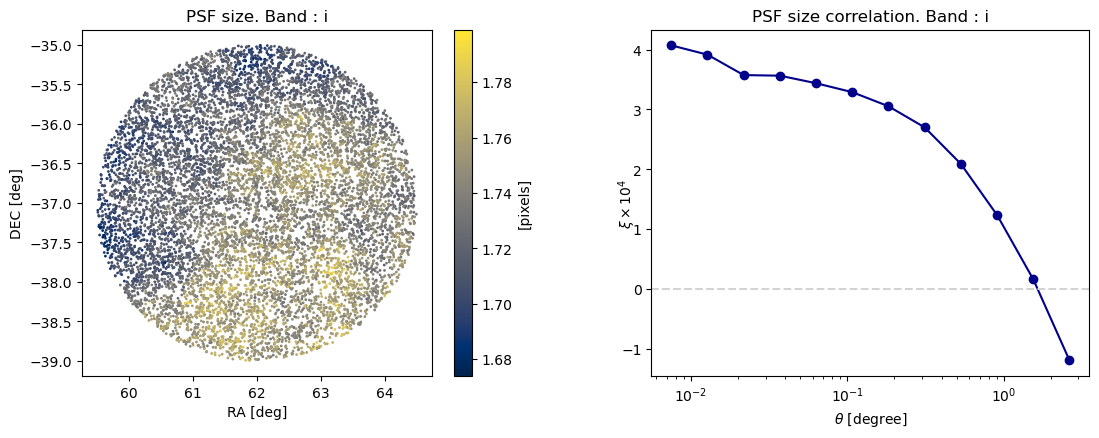

In [59]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5),
                             gridspec_kw={'wspace': .3})

ax1.set_title(f'PSF size. Band : {band}')
scatter_plot = ax1.scatter(ra, dec, c=results_table[f'size_{band}_PSF'],
                           s=1, cmap='cividis')
ax1.set_xlabel('RA [deg]')
ax1.set_ylabel('DEC [deg]')
plt.colorbar(scatter_plot, ax=ax1, label='[pixels]')

ax2.set_title(f'PSF size correlation. Band : {band}')
ax2.plot(np.degrees(bins), xi*1e4, 'o-', color='darkblue')
ax2.axhline(0, linestyle='--', color='lightgrey')
ax2.set_xscale('log')
ax2.set_ylabel(r'$\xi \times 10^{4}$', labelpad=-12)
ax2.set_xlabel(r'$\theta$ [degree]')

plt.show()

#### 3.2 Cone Search around the DC2 center using the `Source` catalog (`calexp` images). 

Let's proceed to recreate the PSF size plot and correlation function, as computed in the previous cells. However, this time we will employ PSF models obtained from `calexp` images instead of `deepCoadd` images. This adjustment will allow us to observe the variation in PSF size within a visit, while still focusing on the `i` band. To achieve this, we'll make use of the `Source` catalog and make slight modifications to the query. Specifically, we will request only the columns that are relevant for our purposes.

In [60]:
query = """
        SELECT TOP 500000
            coord_ra, coord_dec,
            ixy, ixyPSF,
            ixx, iyy, ixxPSF, iyyPSF
        FROM dp02_dc2_catalogs.Source
        WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),
            CIRCLE('ICRS', %s, 2.0)) = 1
            AND detect_isPrimary = 1
            AND calibFlux > 360
            AND extendedness = 0.0
            AND calib_psf_used = 1
            AND pixelFlags_suspectCenter = 0
            AND band = '%s'
        """ % (use_center_coords, band)

results_source = service.search(query)

results_table_source = results_source.to_table().to_pandas()

##### 3.2.1 Size calculation, visualization, and two-point correlation function calculation.

In [64]:
temp = 0.5*(results_table_source['ixxPSF'] + results_table_source['iyyPSF'])
results_table_source['size_i_PSF'] = np.sqrt(temp)

ra_source = results_table_source['coord_ra']
dec_source = results_table_source['coord_dec']

In [65]:
cat = treecorr.Catalog(ra=ra_source, dec=dec_source,
                       k=results_table_source[f'size_{band}_PSF']
                       - np.mean(results_table_source[f'size_{band}_PSF']),
                       ra_units='deg', dec_units='deg')
kk_config = {'max_sep': .06, 'min_sep': .0001, 'nbins': 12}
kk = treecorr.KKCorrelation(kk_config)
kk.process(cat)
xi_source = kk.xi
bins_source = kk.rnom

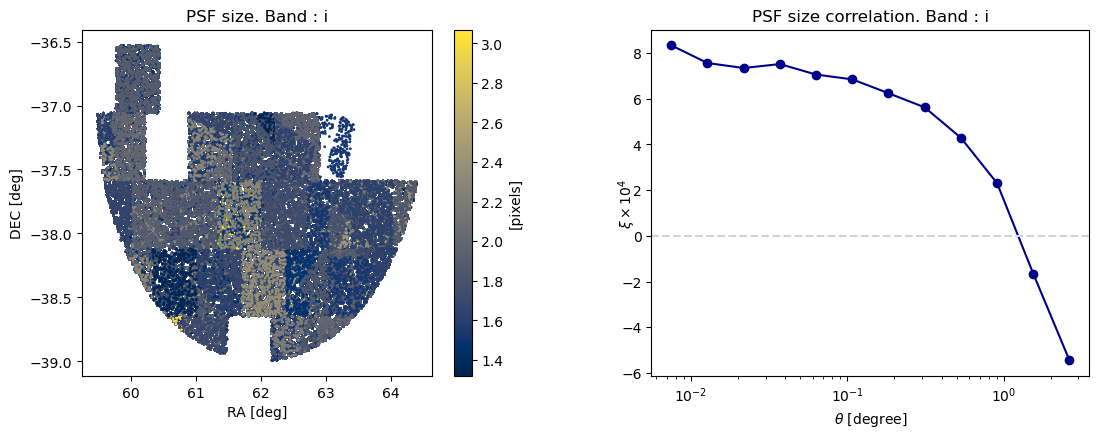

In [66]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5),
                             gridspec_kw={'wspace': .3})

ax1.set_title(f'PSF size. Band : {band}')
scatter_plot = ax1.scatter(ra_source, dec_source,
                           c=results_table_source[f'size_{band}_PSF'],
                           s=1, cmap='cividis')
ax1.set_xlabel('RA [deg]')
ax1.set_ylabel('DEC [deg]')
plt.colorbar(scatter_plot, ax=ax1, label='[pixels]')

ax2.set_title(f'PSF size correlation. Band : {band}')
ax2.plot(np.degrees(bins_source), xi_source*1e4, 'o-', color='darkblue')
ax2.axhline(0, linestyle='--', color='lightgrey')
ax2.set_xscale('log')
ax2.set_ylabel(r'$\xi \times 10^{4}$', labelpad=-12)
ax2.set_xlabel(r'$\theta$ [degree]')

plt.show()

The PSF size exhibits variations at both the tract level and individual visit level. It's important to note that there is no assurance that the sample retrieved from the aforementioned query will be spatially continuous; this may lead to the presence of noticeable gaps in the data.

### 4. Wavelength dependence of seeing  

To correct for the effects of the Point Spread Function (PSF) and to deduce the weak lensing signal (referred to as "shear") from galaxy shapes, the PSF is typically modeled using stars, often bright ones. Subsequently, the PSF of galaxy images is deconvolved by utilizing the estimated PSF convolution kernel. Implicit in this methodology is the assumption that the convolution kernel for galaxies remains the same as that for stars. However, this assumption becomes invalid if the PSF varies with wavelength due to the distinctive Spectral Energy Distributions (SEDs) of stars and galaxies, resulting in disparate PSFs.

In this section, we will leverage the point source sample derived from the `Object` catalog, which was obtained in the preceding sections. Our goal is to compute one of the wavelength-dependent components contributing to the PSF owing to atmospheric effects: the wavelength dependence on seeing. As per the standard theory of atmospheric turbulence, the linear dimension `θ` of the atmospheric convolution kernel (i.e., seeing) is inversely proportional to the wavelength, expressed as `θ ∝ λ**−1/5`.

Additional wavelength-dependent contributions to the PSF encompass Differential Chromatic Refraction (DCR), telescope diffraction, variations in the absorption length of camera CCDs, and optical chromatic aberrations. In general, each of these factors exhibits distinct functional wavelength dependencies and may exert dominance in different spectral bands. Nevertheless, the wavelength-dependent seeing that we explore in this section tends to be the primary contributor to the PSF. These chromatic PSF effects introduce biases in observables such as photometry, astrometry, measurements of galaxy shape and size, and higher-order moments of the PSF. Addressing these effects is imperative for precise cosmological analysis employing weak gravitational lensing. For more detailed information, refer to the works of [Plazas and Bernstein 2012](https://ui.adsabs.harvard.edu/abs/2012PASP..124.1113P/abstract), [Lee et al. 2023](https://ui.adsabs.harvard.edu/abs/2023AJ....165..222L/abstract), [Meyers and Burchat 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...807..182M/abstract), [Tianqing et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.520.2328Z/abstract), and [Meyers and Burchat 2015b](https://ui.adsabs.harvard.edu/abs/2015JInst..10C6004M/abstract).


To replicate this wavelength relationship using our data, we will initiate the process by computing the central wavelengths of the broadband filters employed by LSST, alongside determining the mean size and its standard deviation for each respective band. The boundaries of the filters are available in Table 2.1 of the [LSST Science Book](https://ui.adsabs.harvard.edu/abs/2009arXiv0912.0201L/abstract).

In [67]:
wavelength = 0.5*np.array([320+400, 400+552, 552+691, 691+818])

mean_size = [np.mean(results_table['size_u_PSF']),
             np.mean(results_table['size_g_PSF']),
             np.mean(results_table['size_r_PSF']),
             np.mean(results_table['size_i_PSF'])]

std_size = [np.std(results_table['size_u_PSF']),
            np.std(results_table['size_g_PSF']),
            np.std(results_table['size_r_PSF']),
            np.std(results_table['size_i_PSF'])]

We will proceed to fit a power law to the mean PSF size in relation to wavelength by employing [`scipy.optimize.curvefit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html). This function takes the functional form to be fitted as its first argument, followed by two arrays containing the data. The output is a tuple consisting of the optimized parameters that minimize the squared residuals of the function with respect to the measured data, labeled as `popt`. Additionally, it provides the estimated 2D covariance matrix of the fitted parameters, denoted as `pcov`, wherein the diagonal elements offer an estimation of their respective one-standard-deviation errors (for more comprehensive information, refer to [the documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)).

In [68]:
popt, pcov = curve_fit(power, wavelength, mean_size)
perr = np.sqrt(np.diag(pcov))

In [69]:
lamb_grid = np.arange(300, 800, 1)
fit_size = power(lamb_grid, *popt)
amplitude, exponent = popt
amplitude_error, exponent_error = perr
print(f"Amplitude: {amplitude:.3} +/- {amplitude_error:.3}")
print(f"Exponent: {exponent:.3} +/- {exponent_error:.3}")

Amplitude: 6.32 +/- 0.93
Exponent: 0.196 +/- 0.0235


The fitted exponent, `-0.196 +/- 0.0235` is within one-sigma of the expected value of `-1/5=0.2`. 

The upcoming code cell will generate a plot depicting the mean PSF size (expressed as the trace radius in pixels) in relation to the central wavelength for the previously specified LSST filters. Additionally, a power law fit will be presented on the same plot, with the associated amplitude and fitting parameters indicated within the legend.

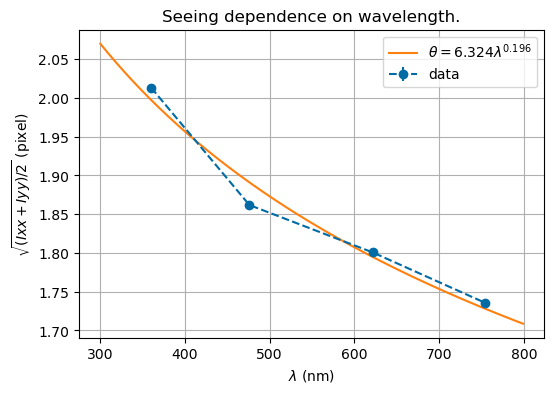

In [71]:
plt.figure(figsize=(6, 4))
plt.errorbar(wavelength, mean_size, std_size/np.sqrt(len(results_table)),
             fmt='o--', label='data')
plt.plot(lamb_grid, fit_size,
         label=r'$\theta = %.3f \lambda^{%.3f}$' % (amplitude, exponent))
plt.title("Seeing dependence on wavelength.")
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel(r'$\sqrt{(Ixx+Iyy)/2}$ (pixel)')
plt.grid()
plt.legend()
plt.show()

In the forthcoming figure, we will superimpose the size distributions per band onto the previously generated plot. The figure includes histograms of the size distributions corresponding to each band (`u`, `g`, `r`, and `i`), rotated 270 degrees to align their bases with the left vertical axis. The upper horizontal axis will display the histogram counts, spanning from 0 to approximately 1200 counts. Notably, this plot serves a dual role, as it incorporates both the data for the PSF size as a function of wavelength and the power-law fit from the preceding plot.

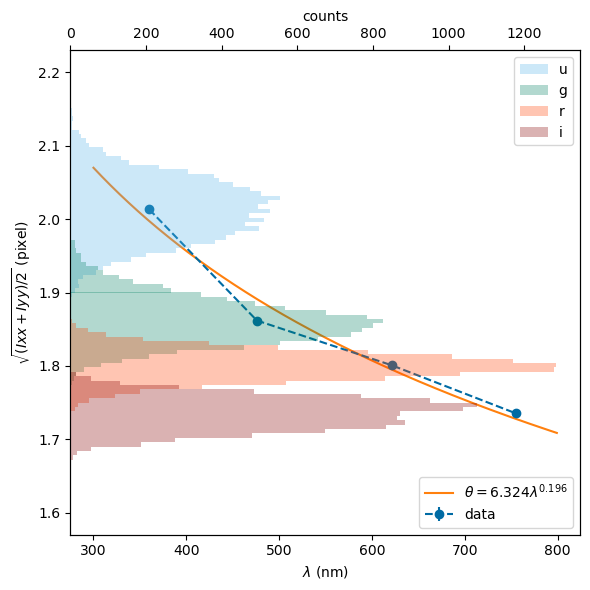

In [72]:
fig, ax1 = plt.subplots(figsize=(6, 6))

color = 'tab:red'
ax1.set_xlabel(r'$\lambda$ (nm)')
ax1.set_ylabel(r'$\sqrt{(Ixx+Iyy)/2}$ (pixel)')
ax1.errorbar(wavelength, mean_size, std_size/np.sqrt(len(results_table)),
             fmt='o--', label='data')
ax1.plot(lamb_grid, fit_size,
         label=r'$\theta = %.3f \lambda^{%.3f}$' % (amplitude, exponent))
ax1.legend(loc='lower right')
ax1.tick_params(axis='y')

ax2 = ax1.twiny()

plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}

ax2.set_xlabel('counts')
plt.hist(results_table['size_u_PSF'], bins=100, range=[1.6, 2.2],
         color=plot_filter_colors['u'], alpha=0.3, label='u',
         orientation="horizontal")
plt.hist(results_table['size_g_PSF'], bins=100, range=[1.6, 2.2],
         color=plot_filter_colors['g'], alpha=0.3, label='g',
         orientation="horizontal")
plt.hist(results_table['size_r_PSF'], bins=100, range=[1.6, 2.2],
         color=plot_filter_colors['r'], alpha=0.3, label='r',
         orientation="horizontal")
plt.hist(results_table['size_i_PSF'], bins=100, range=[1.6, 2.2],
         color=plot_filter_colors['i'], alpha=0.3, label='i',
         orientation="horizontal")
plt.legend()
ax2.tick_params(axis='y')

fig.tight_layout()
plt.show()

### 5. Rho Statistics with Analysis Tools

In this section, we will utilize [`lsst.analysis.tools`](https://github.com/lsst/analysis_tools) to compute the `rho` statistics, which are a collection of two-point correlation functions used to assess the spatial relationships between errors in PSF models. The presence of non-zero values in these statistics signifies the existence of systematic errors in the weak lensing shear correlation function. To understand their definitions, refer to [the analysis tools documentation](https://pipelines.lsst.io/v/daily/py-api/lsst.analysis.tools.actions.vector.CalcRhoStatistics.html#lsst.analysis.tools.actions.vector.CalcRhoStatistics). 

`lsst.analysis.tools` is a package designed to generate quality assurance (QA) plots and metrics from the outputs of the LSST Science Pipelines. It employs `treecorr` to compute the `rho` statistics. For an introductory demonstration of `analysis_tools`, you can refer to [this Jupyter Notebook created for a session during Rubin's 2022 Project and Community Workshop](https://github.com/lsst-dm/analysis_tools_examples/blob/main/analysis_tools_demo_pcw2022.ipynb).

We will begin by creating the `RhoStatistics` analysis structure using the `AnalysisTool`. As outlined in the [2020 Rubin PCW `analysis_tools` demo notebook](https://github.com/lsst-dm/analysis_tools_examples/blob/main/analysis_tools_demo_pcw2022.ipynb), the `AnalysisTool` is one of the three analysis structures provided by `analysis_tools`. It encompasses several `AnalysisAction` components, which collectively conduct specific types of analyses.

In [74]:
atool = RhoStatistics()

There are three types of `AnalysisAction`s or stages: `prep` (for initial filtering of data), `process` (for modyfing the data), and `produce` (for generating final plots of metrics). In the following cells, we will adjust a few configuration parameters from the `prep` and `process` stages.

We'll start with selecting stars with with signal-to-noise ratio (SNR) > 20.

In [75]:
atool.prep.selectors.snSelector.threshold = 20.0

As in a previous section, we can adjust the `treecorr` parameters before calculations, but this time it will be done via `lsst.analysis.tools`.

In [76]:
atool.process.calculateActions.rho.treecorr.nbins = 21
atool.process.calculateActions.rho.treecorr.min_sep = 0.1
atool.process.calculateActions.rho.treecorr.max_sep = 100.0

We need to call `atool.finalize()` after the `atool.prep` and `atool.process` stages are configured.


In [77]:
atool.finalize()

The TAP query in section 3.1 included fields that we did not use in that section, but that will be used in this section. In order to know which entries will be needed by `analysys_tools` to calculate the `rho` statistics, we can look at the input schema of the analysis tool `RhoStatistics`.

In [78]:
input_schema = atool.getInputSchema()
needed_catalog_fields = [name[0] for name in list(atool.getInputSchema())]
print(needed_catalog_fields)

['coord_ra', 'coord_dec', '{band}_ixx', '{band}_iyy', '{band}_ixy', '{band}_ixxPSF', '{band}_iyyPSF', '{band}_ixyPSF', '{band}_psfFlux_flag', '{band}_pixelFlags_saturatedCenter', '{band}_extendedness_flag', 'xy_flag', 'detect_isPatchInner', 'detect_isDeblendedSource', '{band}_psfFlux', '{band}_psfFluxErr', '{band}_extendedness']


Now we are ready to compute the `rho` statistics in the particular band that we have chosen previously (`i`).


We'll start with the `prep` stage in the following cell.

In [79]:
prepResults = atool.prep(results_table, band=f"{band}")


Now we will execute the `process` stage, utilizing the outcomes obtained from the `prep` stage:

In [80]:
processResults = atool.process(prepResults, band=f"{band}")

We can now access the results from `treecorr` for each `rho` statistic in order to examine the values or perform any other operation on them.

In [81]:
print("Mean angular separation:\n", processResults['rho1'].meanr, "\n")
print("Correlation function:\n", processResults['rho1'].xip, "\n")
print("Error in the correlation function:\n", processResults['rho1'].varxip)

Mean angular separation:
 [ 0.12017311  0.1685459   0.23266689  0.32544924  0.44883092  0.62813329
  0.86999208  1.20282896  1.67413031  2.3241002   3.23514482  4.49575909
  6.24488969  8.68315973 12.06400542 16.75441258 23.27609725 32.32357124
 44.88376034 62.2863356  86.25761076] 

Correlation function:
 [-2.52355611e-08  3.59581080e-08  1.78502793e-07 -1.85312869e-08
  1.66952141e-07 -1.09300796e-08  7.95629725e-08  1.95907801e-08
  3.46863274e-08  3.19546135e-08  3.72980681e-08  2.96129858e-08
  2.57193076e-08  4.17031265e-08  2.97849672e-08  3.48310519e-08
  2.87107672e-08  3.61937402e-08  3.44089845e-08  3.52376734e-08
  3.36781249e-08] 

Error in the correlation function:
 [1.61385534e-13 9.82346730e-14 5.05835257e-14 2.84798002e-14
 1.40626399e-14 7.22621795e-15 3.91350603e-15 2.03549322e-15
 1.08277834e-15 5.62739098e-16 2.95487704e-16 1.55025786e-16
 8.06553200e-17 4.24496633e-17 2.23005002e-17 1.18095412e-17
 6.35893513e-18 3.48539955e-18 1.96744389e-18 1.15570814e-18
 7.352

Let's now plot the `rho` statistics using `analysis_tools`: 

By default, the rho statistics are plotted on a symmetric log scale.
The threshold where the switch happens from linear to log scale can be set as follows.

In [61]:
atool.produce.plot.rhoPlots["rho3"].yLinThresh = 1e-8

The following cell will produce six plots of the `rho` statistics. For other possible configuration options, you can refer to the documentation [here](https://pipelines.lsst.io/v/daily/py-api/lsst.analysis.tools.actions.plot.XYPlot.html#lsst.analysis.tools.actions.plot.XYPlot). The vertical axis of each plot displays the specific `rho` statistic, and the horizontal axis represents the separation in arcminutes, ranging from approximately 0.01 to 100 arcminutes on a logarithmic scale.

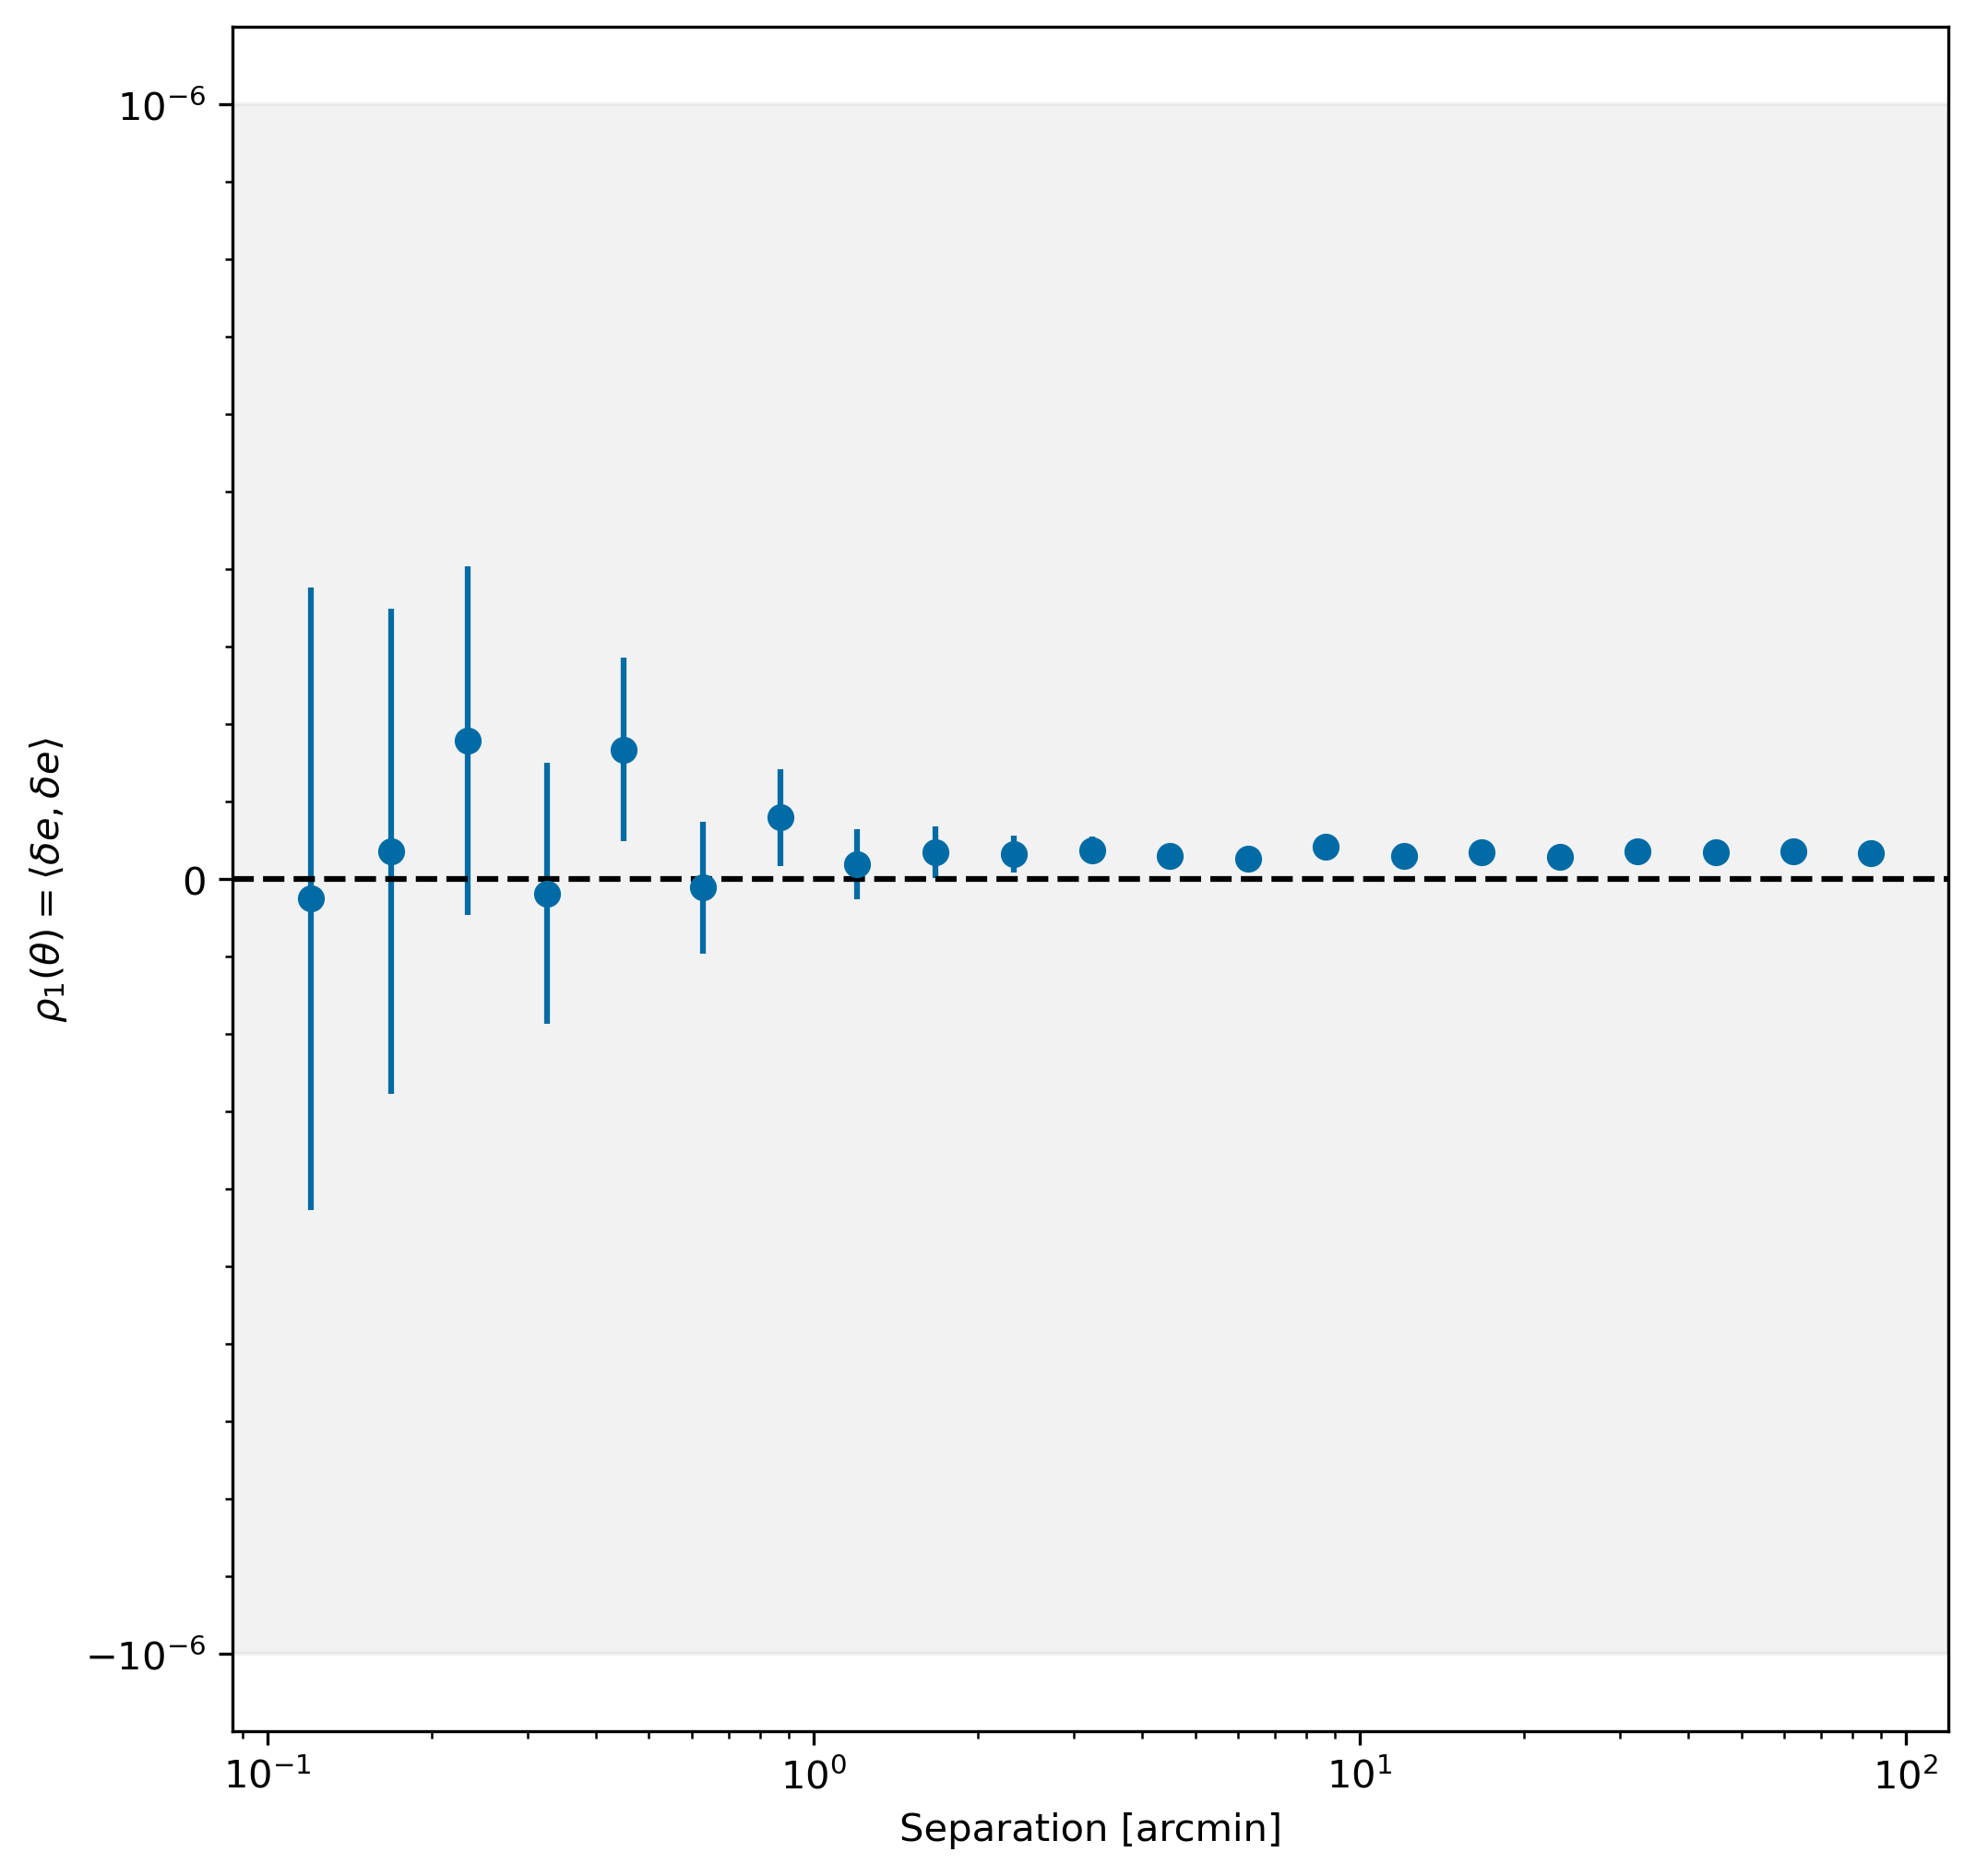

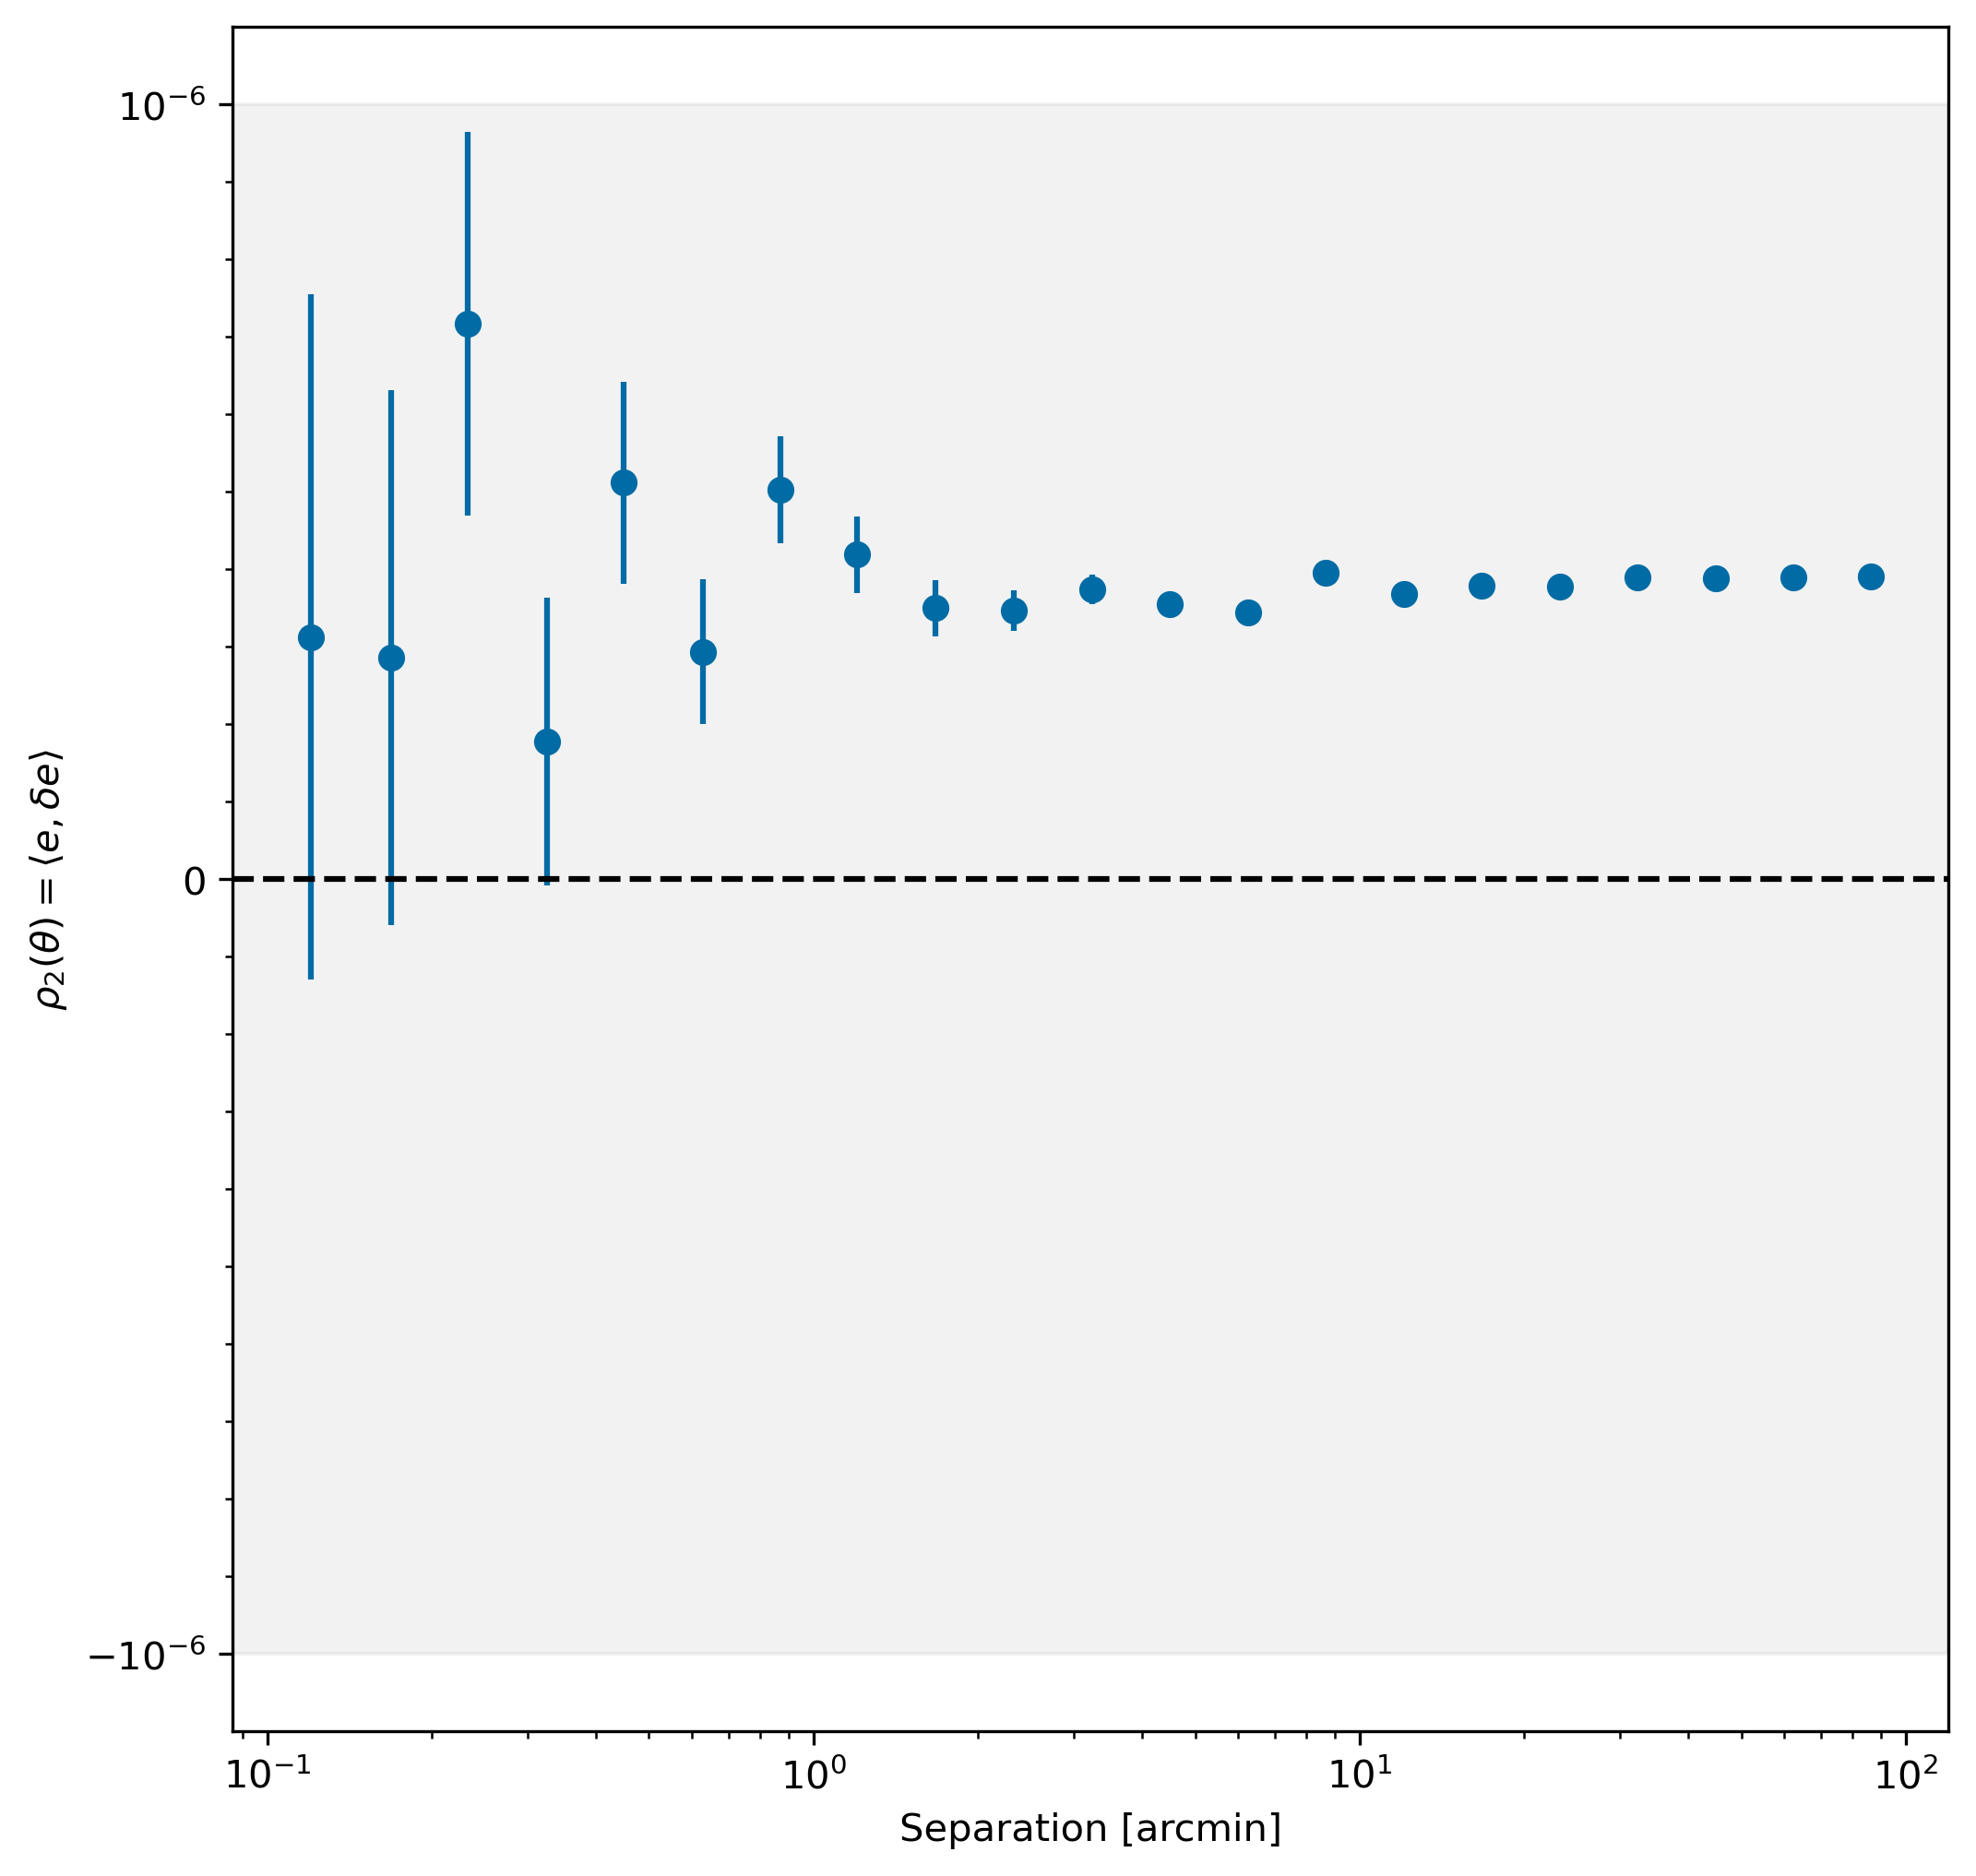

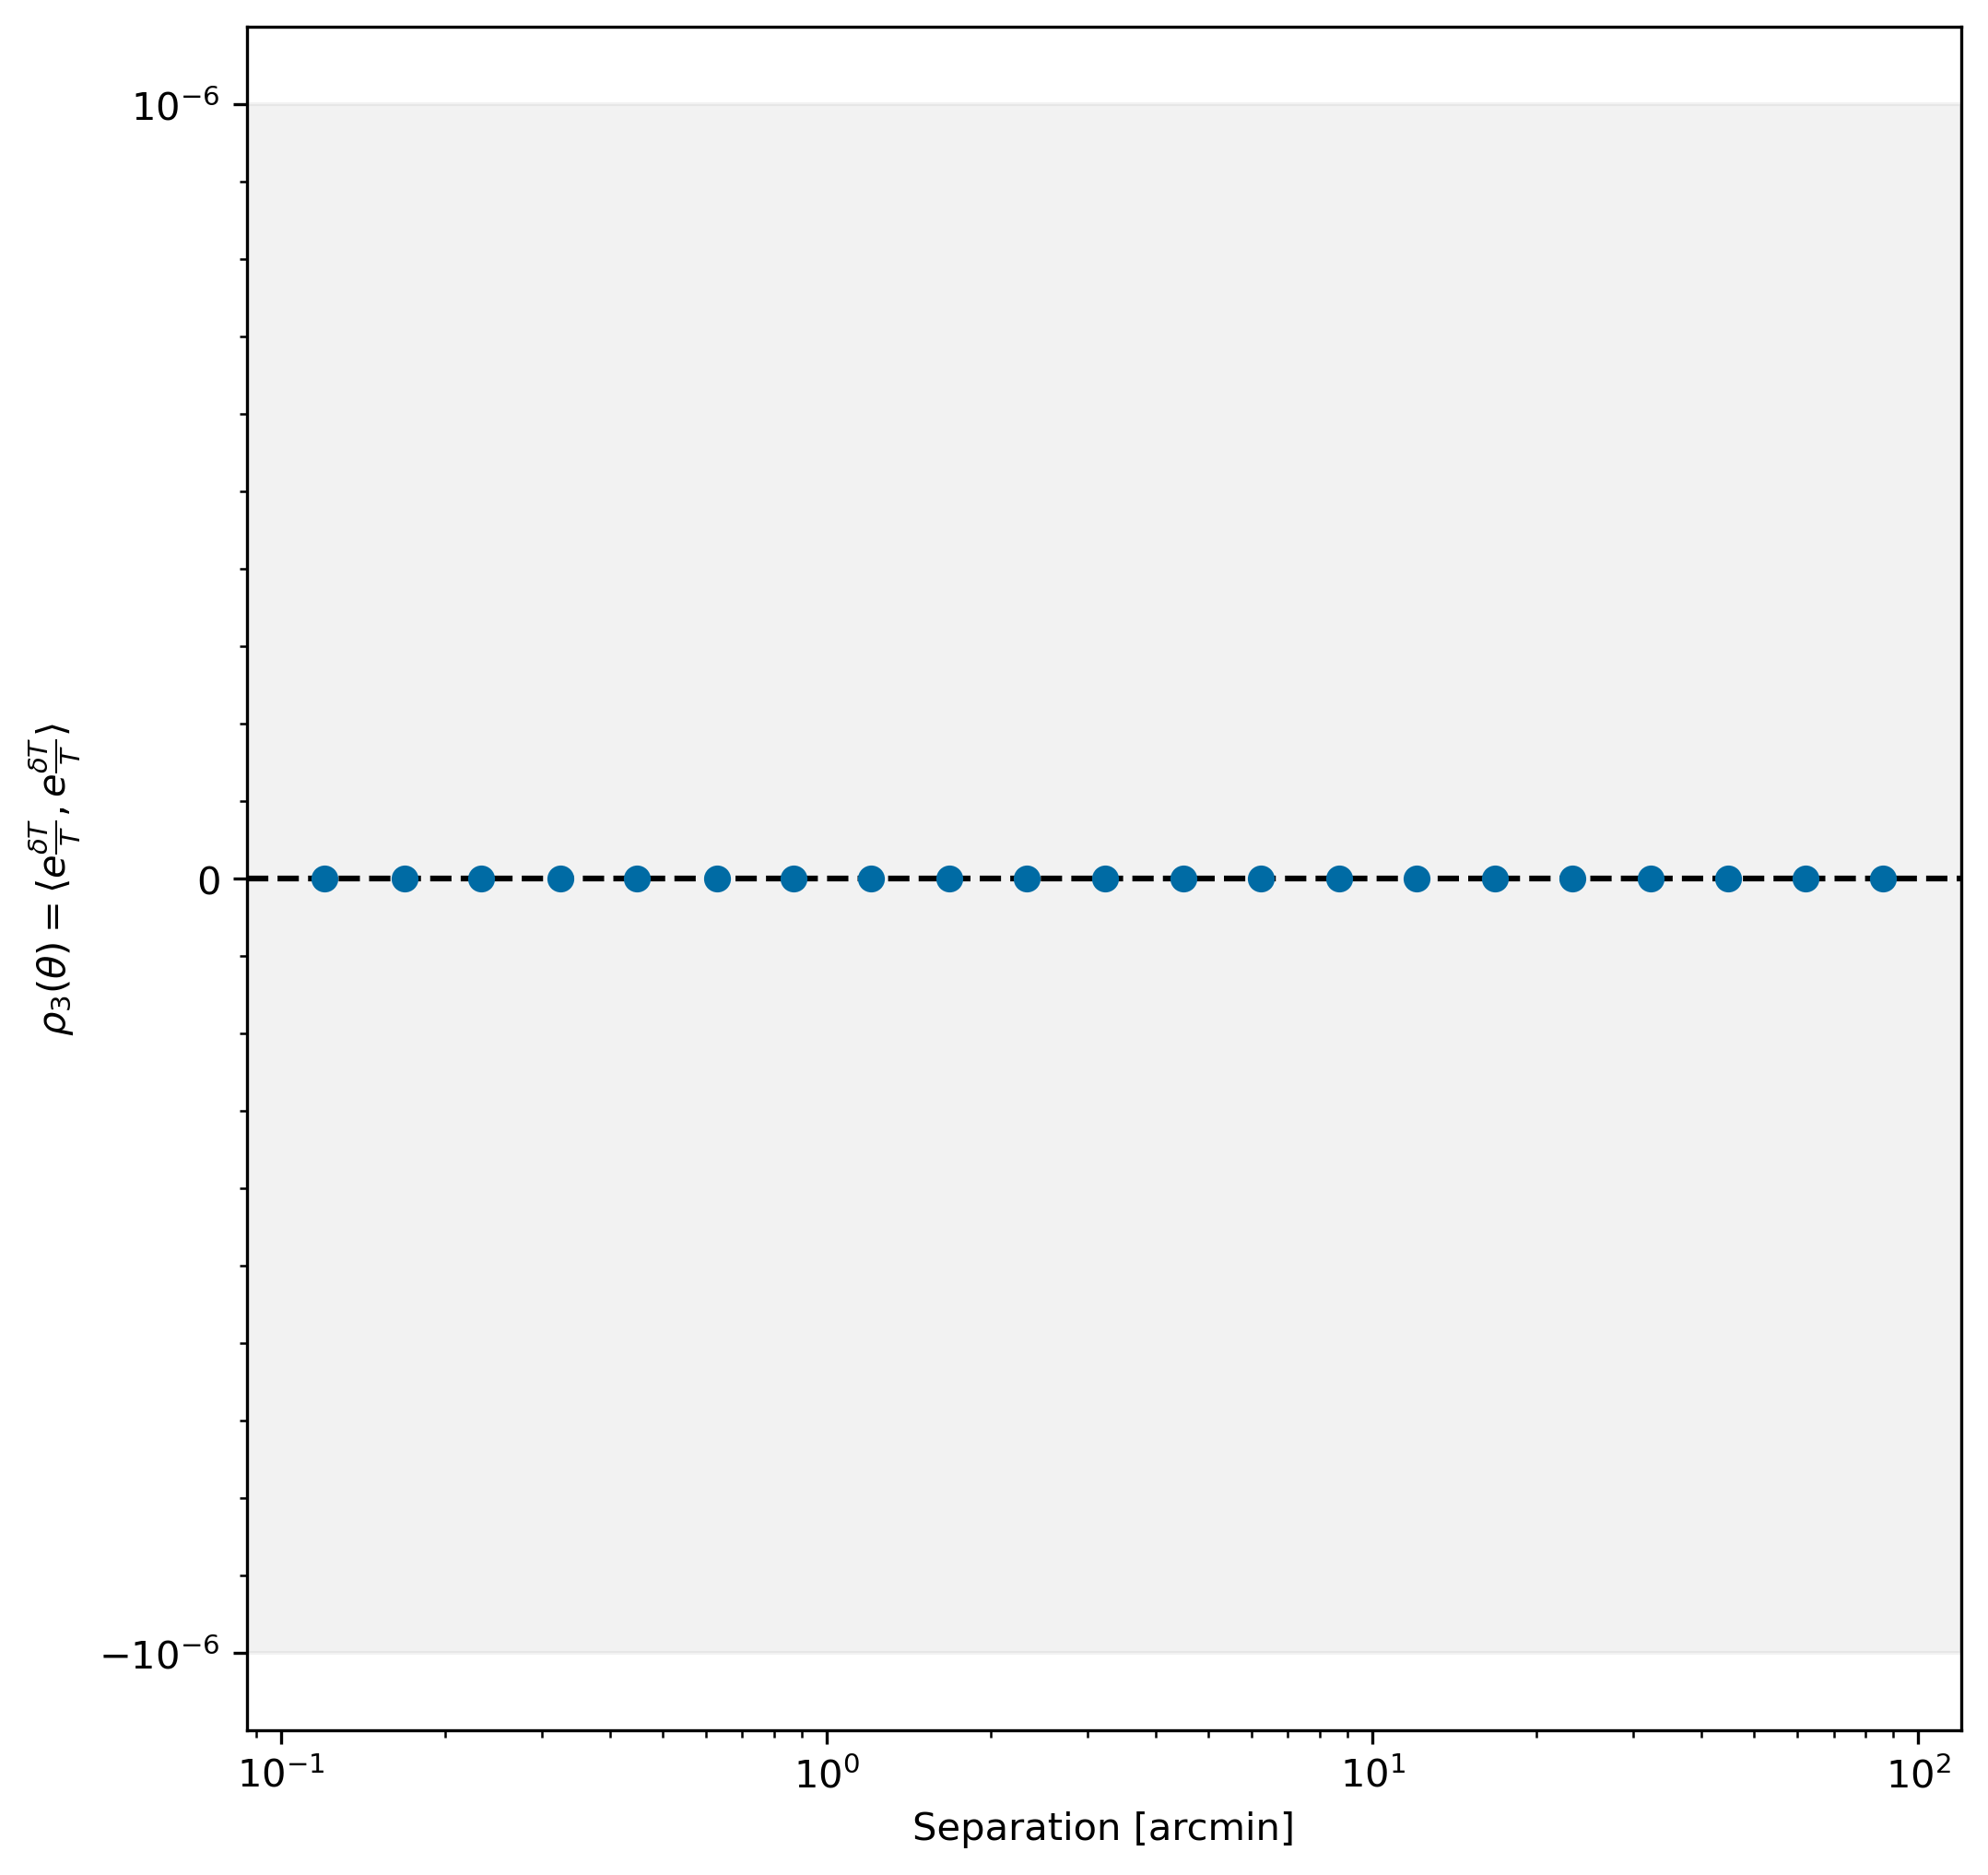

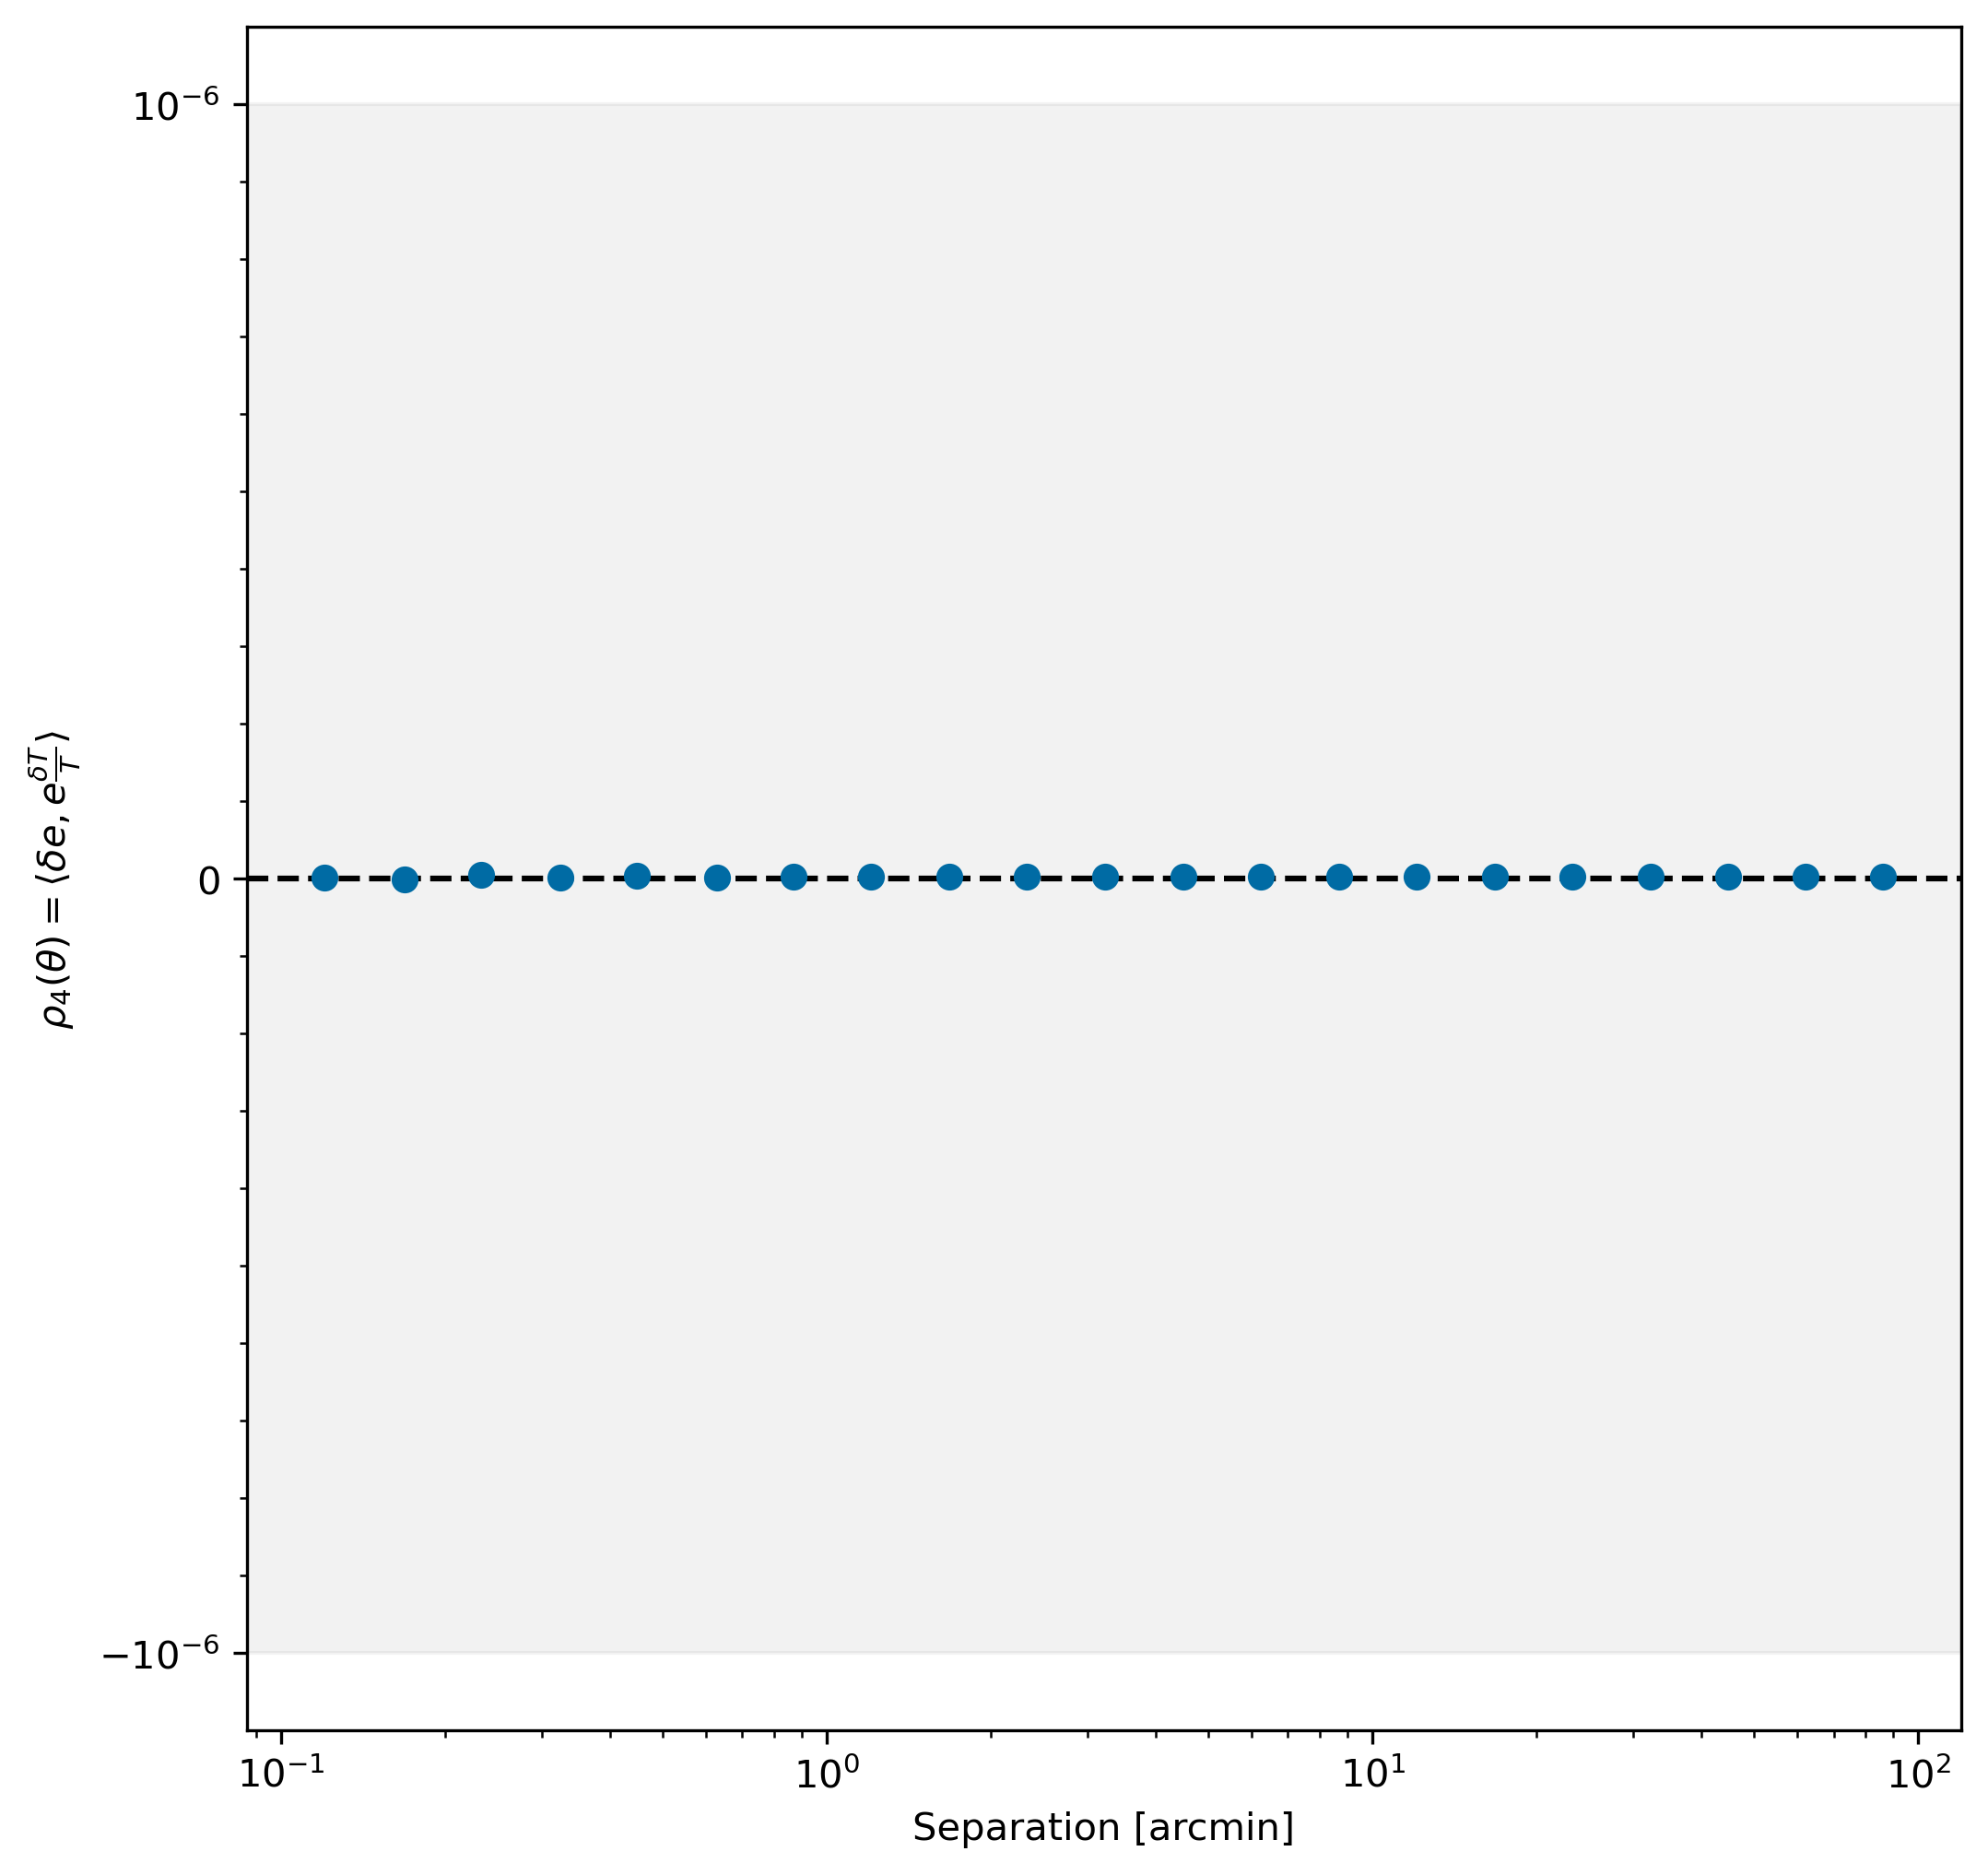

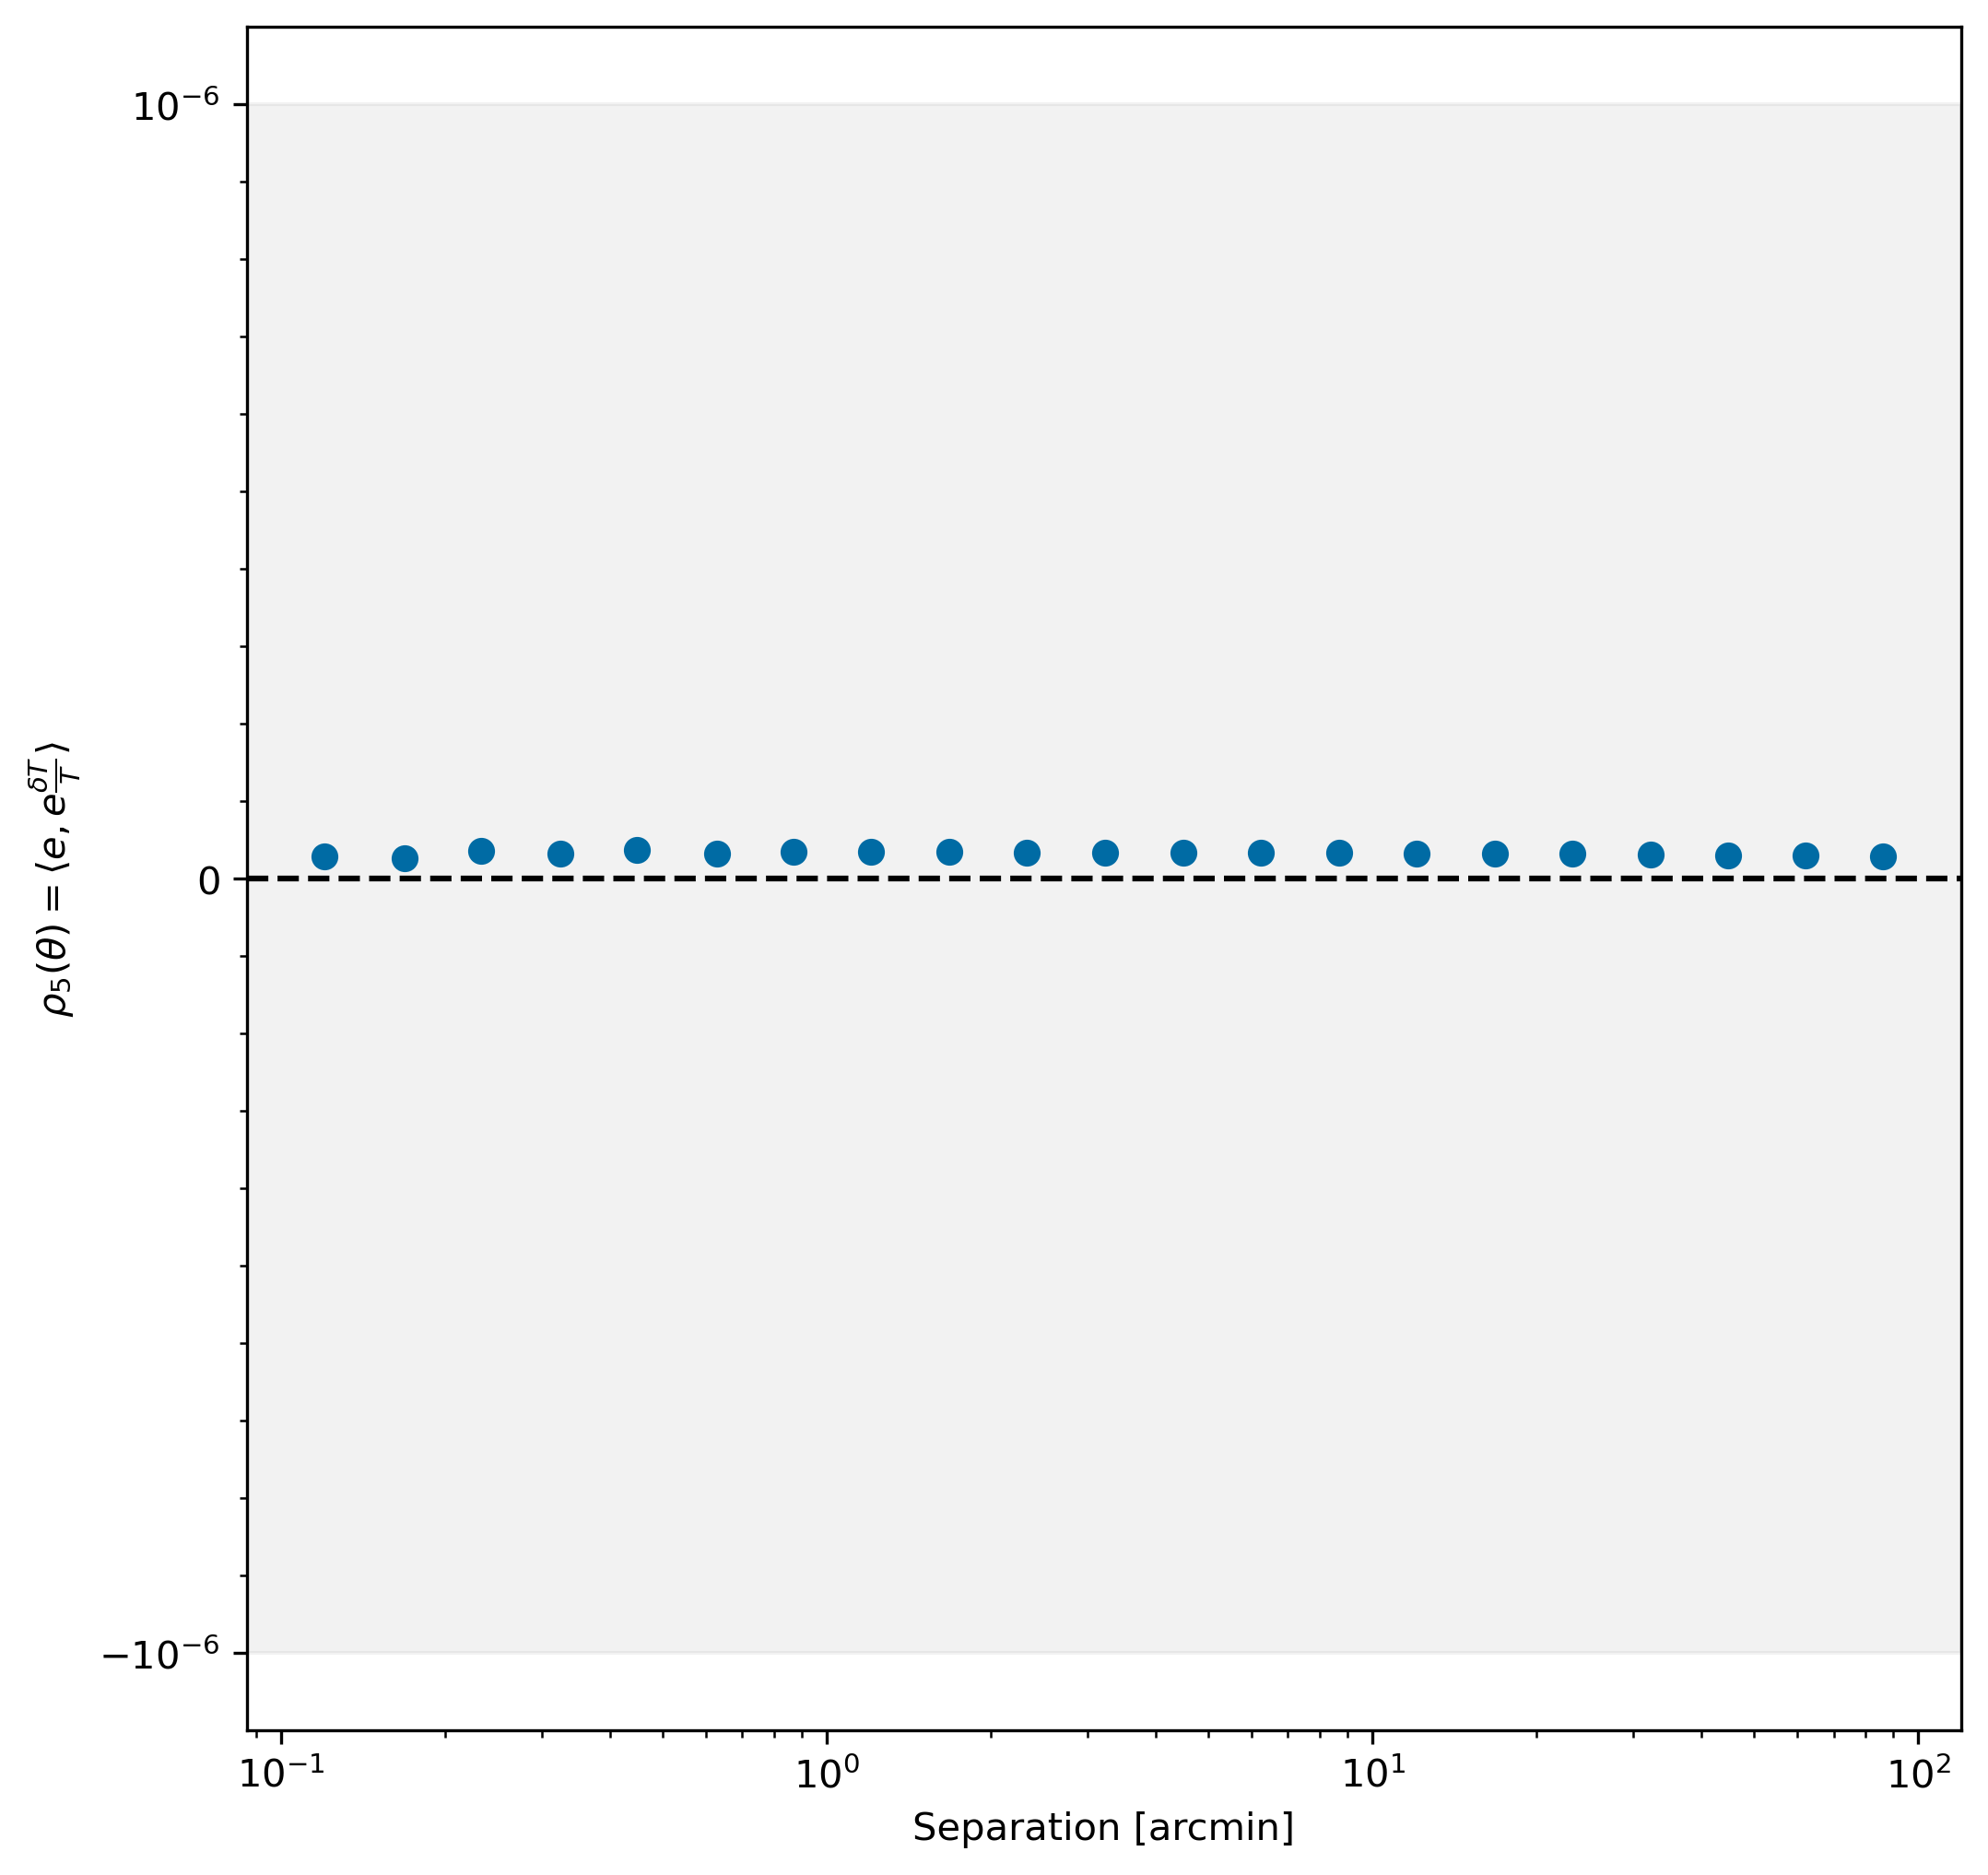

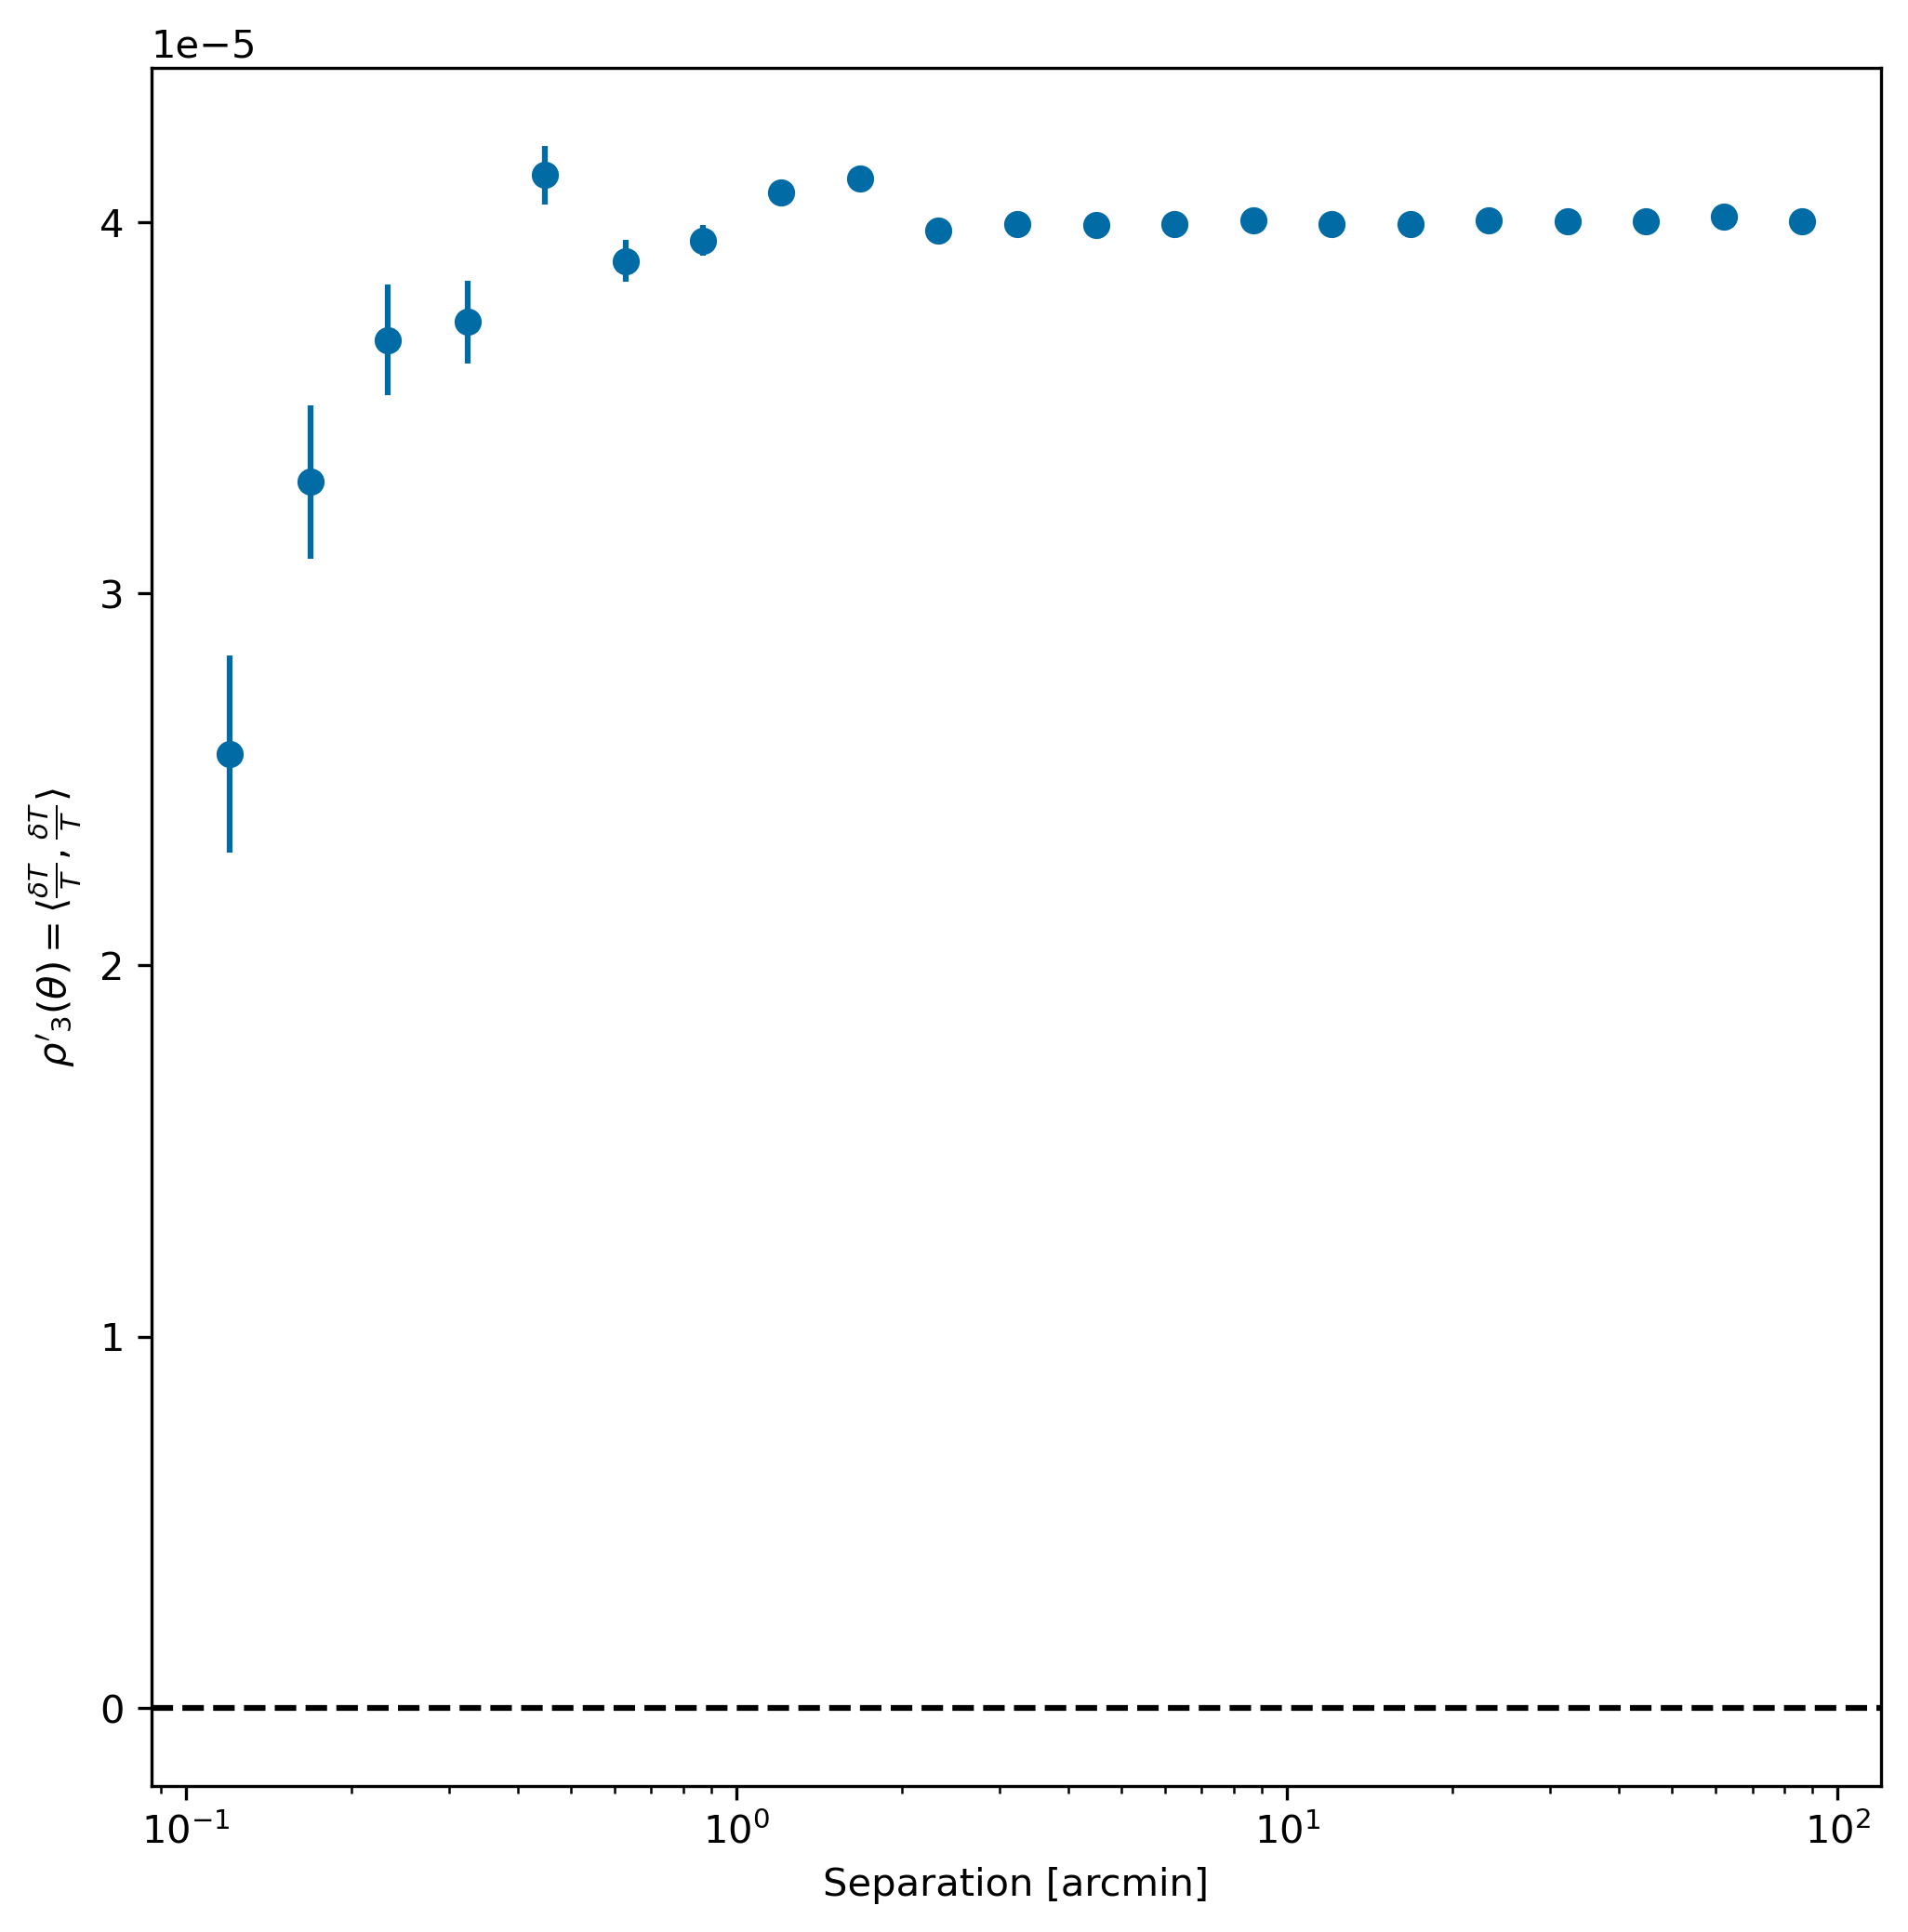

In [82]:
produceResults = atool.produce(processResults, band=f"{band}", skymap=None)

As explained in [Jarvis et al. 2020](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract), `rho1` (ρ1), `rho3` (ρ3), and `rho4` (ρ4) represent direct systematic errors in `xi+` (ξ+) with leading coefficients of order unity. `rho2` (ρ2) and `rho5` (ρ5) describe the extent of "PSF leakage" that occurs during the shear measurement process.

The DC2 area is relatively small and does not exhibit significant PSF variations. The `rho` statistics obtained in the previous examples (for the `i` band, considering that `rho` statistics can vary with different bands) are relatively small and well-behaved. For comparison, you can refer to Figure 26 of the [HSC Y3 shape catalog](https://ui.adsabs.harvard.edu/abs/2022PASJ...74..421L/abstract) and Figure 12 of the [DES Y3 shape catalog analyses](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract), which display `rho` statistics obtained from on-sky data from their respective galaxy surveys (HSC Survey and DES). These figures also include the requirements that each `rho` statistic should satisfy (e.g., Eq. 37 of [Li et al. 2021](https://ui.adsabs.harvard.edu/abs/2022PASJ...74..421L/abstract)) to ensure that there are no significant PSF modeling systematic errors that would impact the scientific goals related to cosmic shear.

### Exercises for the Learner

#### Section 2:

* a) In the `radialAverageAndFit` function of the `ImageExaminer` class, try using a different functional form for fitting the one-dimensional PSF radial profiles, such as the Moffat profile (as described in Eq. 3.6 of [Jarvis et al. 2020](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract)).

* b) Extend the analysis of the one-dimensional PSF radial profiles by calculating additional statistics such as skewness and kurtosis, and visualize them to gain insights into the PSF behavior.

#### Section 3:
* a) Calculate the PSF ellipticity using the definition based on the second moments, as described in Eq. 7.5 of [Jarvis et al. 2020](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract). Create plots similar to those in section 3.2 to visualize the PSF ellipticity variation across the image.

* b) Modify the query in section 3.1 to retrieve both point sources and extended sources. Create a size-magnitude diagram using the definition of size from section 3.2. Identify the region in the diagram where the size is constant, representing likely stars during the star-galaxy separation process. Compare your results with Figure 3 in [Jarvis et al. 2020](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract).

#### Section 5: 
* a) Modify the query in section 3.1 to retrieve the required catalog fields according to the input schema for the `RhoStatistics` of `analysis_tools`. Calculate the `rho` statistics for a different band, such as the `g` band. Note that chromatic effects, including Differential Chromatic Refraction (DCR) and wavelength-dependent seeing, have a larger impact in the bluer bands. Use the `rho` statistics as a diagnostic tool to assess whether observations in these bluer bands should be included in weak lensing analyses (refer to the discussion in section 7.4 of [Jarvis et al. 2020](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.1282J/abstract)).
